In [1]:
# ========================= Importar Librerias ======================================

import matplotlib.pyplot as plt
import thejoker.units as xu
import scipy.stats as stats
import astropy.units as u
import statistics as stat
import seaborn as sns
import thejoker as tj
import pandas as pd
import numpy as np
import arviz as az
import pymc as pm
import warnings
warnings.filterwarnings('ignore')
import inspect
import corner
import math 
import h5py
import csv
import os


from astropy.visualization.units import quantity_support
from thejoker import JokerPrior, TheJoker, RVData
from sklearn.metrics import mean_squared_error
from thejoker.plot import plot_rv_curves
from scipy.stats import gaussian_kde
from astropy.time import Time
from os.path import join
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [2]:
def BMJD_to_hms(bmjd):
    # Convertir BMJD a JD (suponiendo que BMJD es similar a MJD)
    jd = bmjd + 2400000.5
    
    # Convertir JD a una fecha estándar usando astropy
    fecha = Time(jd, format='jd').to_value('iso', subfmt='date_hms')
    return fecha

In [3]:
# Configurar el estilo de fuente global a 'serif'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif', 'Bitstream Vera Serif', 'Computer Modern Roman', 'New Century Schoolbook', 'Century Schoolbook L', 'Utopia', 'ITC Bookman', 'Bookman', 'Nimbus Roman No9 L', 'Palatino', 'Charter', 'serif']

In [4]:
# ========================= Definición de Funciones ======================================
def seleccionar_distribuciones(familia='realall', verbose=True):
    '''
    Esta función selecciona un subconjunto de las distribuciones disponibles
    en scipy.stats
    
    Parameters
    ----------
    familia : {'realall', 'realline', 'realplus', 'real0to1', 'discreta'}
        realall: distribuciones de la familia `realline` + `realplus`
        realline: distribuciones continuas en el dominio (-inf, +inf)
        realplus: distribuciones continuas en el dominio [0, +inf)
        real0to1: distribuciones continuas en el dominio [0,1]
        discreta: distribuciones discretas
        
    verbose : bool
        Si se muestra información de las distribuciones seleccionadas
        (the default `True`).
        
    Returns
    -------
    distribuciones: list
        listado con las distribuciones (los objetos) seleccionados.
        
    Raises
    ------
    Exception
        Si `familia` es distinto de 'realall', 'realline', 'realplus', 'real0to1',
        o 'discreta'.
        
    Notes
    -----
        Las distribuciones levy_stable y vonmises han sido excluidas por el momento.

    '''
    
    distribuciones = [getattr(stats,d) for d in dir(stats) \
                     if isinstance(getattr(stats,d), (stats.rv_continuous, stats.rv_discrete))]
    
    exclusiones = ['levy_stable', 'vonmises']
    distribuciones = [dist for dist in distribuciones if dist.name not in exclusiones]
            
    dominios = {
        'realall' : [-np.inf, np.inf],
        'realline': [np.inf,np.inf],
        'realplus': [0, np.inf],
        'real0to1': [0, 1], 
        'discreta': [None, None],
    }

    distribucion = []
    tipo = []
    dominio_inf = []
    dominio_sup = []

    for dist in distribuciones:
        distribucion.append(dist.name)
        tipo.append(np.where(isinstance(dist, stats.rv_continuous), 'continua', 'discreta'))
        dominio_inf.append(dist.a)
        dominio_sup.append(dist.b)
    
    info_distribuciones = pd.DataFrame({
                            'distribucion': distribucion,
                            'tipo': tipo,
                            'dominio_inf': dominio_inf,
                            'dominio_sup': dominio_sup
                          })

    info_distribuciones = info_distribuciones \
                          .sort_values(by=['dominio_inf', 'dominio_sup'])\
                          .reset_index(drop=True)
    
    if familia in ['realall', 'realline', 'realplus', 'real0to1']:
        info_distribuciones = info_distribuciones[info_distribuciones['tipo']=='continua']
        condicion = (info_distribuciones['dominio_inf'] == dominios[familia][0]) & \
                    (info_distribuciones['dominio_sup'] == dominios[familia][1]) 
        info_distribuciones = info_distribuciones[condicion].reset_index(drop=True)
        
    if familia in ['discreta']:
        info_distribuciones = info_distribuciones[info_distribuciones['tipo']=='discreta']
        
    seleccion = [dist for dist in distribuciones \
                 if dist.name in info_distribuciones['distribucion'].values]
    
    
    if verbose:
        print("---------------------------------------------------")
        print("       Distribuciones seleccionadas                ")
        print("---------------------------------------------------")
        with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
            print(info_distribuciones)
    
    return seleccion


def comparar_distribuciones(x, familia='realall', ordenar='aic', verbose=True):
    '''
    Esta función selecciona y ajusta un subconjunto de las distribuciones 
    disponibles en scipy.stats. Para cada distribución calcula los valores de
    Log Likelihood, AIC y BIC.
    
    Parameters
    ----------
    x : array_like
        datos con los que ajustar la distribución.
        
    familia : {'realall', 'realline', 'realplus', 'real0to1', 'discreta'}
        realall: distribuciones de la familia `realline` + `realplus`
        realline: distribuciones continuas en el dominio (-inf, +inf)
        realplus: distribuciones continuas en el dominio [0, +inf)
        real0to1: distribuciones continuas en el dominio [0,1]
        discreta: distribuciones discretas
    
    ordenar : {'aic', 'bic'}
        criterio de ordenación de mejor a peor ajuste.
    
    verbose : bool
        Si se muestra información de las distribuciones seleccionadas
        (the default `True`).
        
    Returns
    -------
    resultados: data.frame
        distribucion: nombre de la distribución.
        log_likelihood: logaritmo del likelihood del ajuste.
        aic: métrica AIC.
        bic: métrica BIC.
        n_parametros: número de parámetros de la distribución de la distribución.
        parametros: parámetros del tras el ajuste
        
    Raises
    ------
    Exception
        Si `familia` es distinto de 'realall', 'realline', 'realplus', 'real0to1',
        o 'discreta'.
        
    Notes
    -----

    '''
    
    distribuciones = seleccionar_distribuciones(familia=familia, verbose=verbose)
    distribucion_ = []
    log_likelihood_= []
    aic_ = []
    bic_ = []
    n_parametros_ = []
    parametros_ = []
    
    for i, distribucion in enumerate(distribuciones):
        
        print(f"{i+1}/{len(distribuciones)} Ajustando distribución: {distribucion.name}")
        
        try:
            parametros = distribucion.fit(data=x)
            nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                                 if not p=='x'] + ["loc","scale"]
            parametros_dict = dict(zip(nombre_parametros, parametros))
            log_likelihood = distribucion.logpdf(x, *parametros).sum()
            aic = -2 * log_likelihood + 2 * len(parametros)
            bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)
            
            distribucion_.append(distribucion.name)
            log_likelihood_.append(log_likelihood)
            aic_.append(aic)
            bic_.append(bic)
            n_parametros_.append(len(parametros))
            parametros_.append(parametros_dict)
            
            resultados = pd.DataFrame({
                            'distribucion': distribucion_,
                            'log_likelihood': log_likelihood_,
                            'aic': aic_,
                            'bic': bic_,
                            'n_parametros': n_parametros_,
                            'parametros': parametros_,
                
                         })
            
            resultados = resultados.sort_values(by=ordenar).reset_index(drop=True)
            
        except Exception as e:
            print(f"Error al tratar de ajustar la distribución {distribucion.name}")
            print(e)
            print("")
            
    return resultados

In [9]:
def plot_distribucion(x, nombre_distribucion, bin, label, unit, ax=None):
    '''
    Esta función superpone la curva de densidad de una distribución con el
    histograma de los datos.
    
    Parameters
    ----------
    x : array_like
        datos con los que ajustar la distribución.
        
    nombre_distribuciones : str
        nombre de una de las distribuciones disponibles en `scipy.stats`.
        
    Returns
    -------
    resultados: matplotlib.ax
        gráfico creado
        
    Raises
    ------
        
    Notes
    -----
    '''

    distribucion = getattr(stats, nombre_distribucion)

    parametros = distribucion.fit(data=x)

    nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                         if not p=='x'] + ["loc","scale"]
    parametros_dict = dict(zip(nombre_parametros, parametros))

    log_likelihood = distribucion.logpdf(x, *parametros).sum()

    aic = -2 * log_likelihood + 2 * len(parametros)
    bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

    x_hat = np.linspace(min(x), max(x), num=100)
    y_hat = distribucion.pdf(x_hat, *parametros)
    P_max = x_hat[np.argmax(y_hat)]
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,4))
        
    ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
    ax.hist(x=x, density=True, bins=bin, color="#3182bd", alpha=0.5,edgecolor = '#3F4750');
    ax.plot(x, np.full_like(x, 0), '|k', markeredgewidth=1)
    plt.axvline(P_max, color='#E74C3C', linestyle='--', label=f'Máximo en {label} = {P_max:.5f} {unit}')
    ax.set_title('Ajuste distribución')
    ax.set_xlabel(f'{label} [{unit}]')
    ax.set_ylabel('Densidad de probabilidad')
    ax.legend();

    print('---------------------')
    print('Resultados del ajuste')
    print('---------------------')
    print(f"Distribución:   {distribucion.name}")
    print(f"Dominio:        {[distribucion.a, distribucion.b]}")
    print(f"Parámetros:     {parametros_dict}")
    print(f"Log likelihood: {log_likelihood}")
    print(f"AIC:            {aic}")
    print(f"BIC:            {bic}")
    print(f"{label}_max:          {P_max} {unit}")
    return ax


def plot_multiple_distribuciones(x, nombre_distribuciones, bin, label, unit, ax=None):
    '''
    Esta función superpone las curvas de densidad de varias distribuciones
    con el histograma de los datos.
    
    Parameters
    ----------
    x : array_like
        datos con los que ajustar la distribución.
        
    nombre_distribuciones : list
        lista con nombres de distribuciones disponibles en `scipy.stats`.
        
    Returns
    -------
    resultados: matplotlib.ax
        gráfico creado
        
    Raises
    ------
        
    Notes
    -----
    '''
    aic_list = []
    bic_list = []
    nombres = []
    Best_fit = pd.DataFrame()
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,4))
        
    ax.hist(x=x, density=True, bins=bin, color="#3182bd", alpha=0.5,edgecolor = '#3F4750')
    ax.plot(x, np.full_like(x, 0), '|k', markeredgewidth=1)
    ax.set_title('Ajuste distribuciones')
    ax.set_xlabel(f'{label} [{unit}]')
    ax.set_ylabel('Densidad de probabilidad')
    
    for nombre in nombre_distribuciones:
        
        distribucion = getattr(stats, nombre)

        parametros = distribucion.fit(data=x)

        nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                             if not p=='x'] + ["loc","scale"]
        parametros_dict = dict(zip(nombre_parametros, parametros))

        log_likelihood = distribucion.logpdf(x, *parametros).sum()

        aic = -2 * log_likelihood + 2 * len(parametros)
        bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)
        aic_list.append(aic)
        bic_list.append(bic)
        nombres.append(distribucion.name)
        
        x_hat = np.linspace(min(x), max(x), num=100)
        y_hat = distribucion.pdf(x_hat, *parametros)
        ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
        
    ax.legend();
    
    Best_fit["Distribución"] = nombres
    Best_fit["AIC"] = aic_list
    Best_fit["BIC"] = bic_list
    Best_fit = Best_fit.sort_values(by='BIC')
    return ax, Best_fit

In [11]:
# Lee el archivo de texto y crea un DataFrame
nombres_columnas = ['Estrella', 'TYC', '2MASS']
data = pd.read_csv('Nombres_de_Estrellas.txt', delimiter=' ', names=nombres_columnas, header=None)  # Si el archivo está tabulado, usa '\t' como separador
data

,Estrella,TYC,2MASS
0,Krich_1,TYC22-591-1,2MASSJ01030596+0434459
1,Krich_2,TYC26-777-1,2MASSJ01194936+0634115
2,Na_rich,TYC6908-1643-1,2MASSJ20320320-2332524
3,Nrich_1,TYC4686-2039-1,2MASSJ01575297-0316508
4,Nrich_2,TYC8517-1671-1,2MASSJ05120630-5913438
5,Nrich_3,TYC244-273-1,2MASSJ10022398+0216045
6,Nrich_4,TYC250-1352-1,2MASSJ10071742+0605101
7,Nrich_5,TYC269-474-1,2MASSJ11173689+0645217
8,Nrich_6,TYC7408-694-1,2MASSJ18461977-3021506
9,Nrich_7,TYC5256-183-1,2MASSJ23513172-0312308


In [13]:
columns = ["Star","Date","RV","err_RV", "S/N"]
Estrella = {}
mean = []
range = []
std = []
for i in data["Estrella"]:
    Estrella[i] = pd.read_csv(i+'.dat', delimiter='\t', names=columns, header=None)
    #print(Estrella[i])
    mean.append(np.mean(Estrella[i]["RV"]))
    range.append(np.max(Estrella[i]["RV"])-np.min(Estrella[i]["RV"]))
    std.append(np.std(Estrella[i]["RV"]))

In [15]:
Estrella["Nrich_4"]

,Star,Date,RV,err_RV,S/N
0,TYC250-1352-1,2.459616e+06,-16.4503,0.1149,17
1,TYC250-1352-1,2.459645e+06,-17.2516,0.0666,22
2,TYC250-1352-1,2.459667e+06,-18.8204,0.0977,29


In [17]:
# Obtén la ruta absoluta
file_path = os.path.abspath('news_RV/Nrich4_2M10071742+0605101.csv')
print(file_path)

# Luego intenta leer el archivo
df = pd.read_csv(file_path)
df_ordenado = df.sort_values(by='JD')
df_ordenado

C:\Users\Alexander\Desktop\Docs_Jupyter\9.Joven_Investigador\Nrich\news_RV\Nrich4_2M10071742+0605101.csv


,APOGEE_ID,TARGET_ID,MJD,SNR,STARFLAG,STARFLAGS,DATEOBS,JD,VRELERR,VHELIO
1,2M10071742+0605101,2M10071742+0605101,58549,243168,0,NaN,2019-03-07T04:28:40.060,2.458550e+06,0.031455,-16.176062
2,2M10071742+0605101,2M10071742+0605101,58566,184804,0,NaN,2019-03-24T03:35:33.301,2.458567e+06,0.041044,-16.340077
0,2M10071742+0605101,2M10071742+0605101,58567,199456,0,NaN,2019-03-25T04:20:07.007,2.458568e+06,0.037978,-16.287560


findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


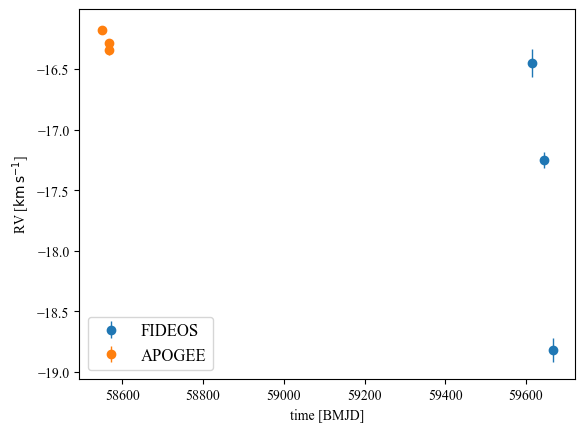

In [19]:
fideos_data = tj.RVData(
    t=np.array(Estrella["Nrich_4"]["Date"])-2400000.5,
    rv=np.array(Estrella["Nrich_4"]["RV"]) * u.km/u.s,
    rv_err=np.array(Estrella["Nrich_4"]["err_RV"]) * u.km/u.s,
)

apogee_data = tj.RVData(
    t=np.array(df_ordenado["JD"])-2400000.5,
    rv=np.array(df_ordenado["VHELIO"])* u.km/u.s,
    rv_err=np.array(df_ordenado["VRELERR"])* u.km/u.s,
)

for d, name in zip([fideos_data, apogee_data], ["FIDEOS", "APOGEE"]):
    d.plot(color=None, label=name)
plt.legend(fontsize=12)

In [21]:
t = np.concatenate((np.array(df_ordenado["JD"]),np.array(Estrella["Nrich_4"]["Date"])))-2400000.5
rv = np.concatenate((np.array(df_ordenado["VHELIO"]),np.array(Estrella["Nrich_4"]["RV"]))) * u.km/u.s
err = np.concatenate((np.array(df_ordenado["VRELERR"]),np.array(Estrella["Nrich_4"]["err_RV"]))) * u.km/u.s
data = tj.RVData(t=t, rv=rv, rv_err=err)

### The Joker | Con wave

Estos datos fueron calculados teniendo en cuenta los siguientes parámetros.

$$P_{min} = 2 ~días$$
$$P_{max} = e^8 ~días$$
$$sigma\_K0=30 * u.km / u.s$$
$$sigma\_v=100 * u.km / u.s$$

Además el número de priors que se logró establecer es $J=2^{25}$

In [24]:
samples = tj.JokerSamples.read("TJ_samples_Nrich4.hdf5")
samples

<JokerSamples [P, e, omega, M0, s, K, v0] (504 samples)>

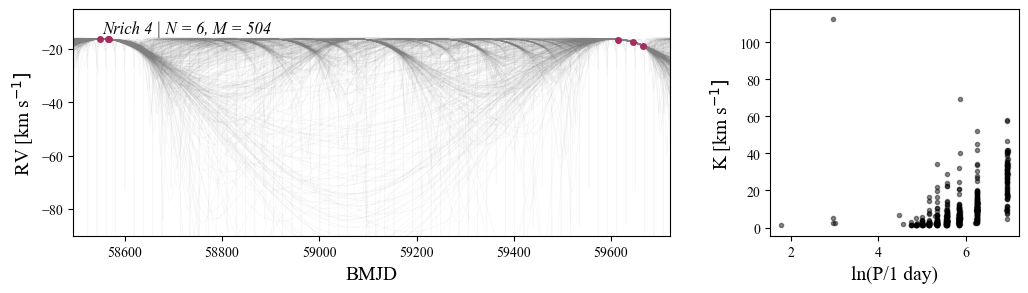

In [26]:
fig = plt.figure(figsize=(22,10))

gs = fig.add_gridspec(nrows=3, ncols=3, left=0.05, right=0.48, wspace=0.4)
f_ax1 = fig.add_subplot(gs[-1, :-1])
f_ax2 = fig.add_subplot(gs[-1,-1])

_ = tj.plot_rv_curves(samples,data=data,plot_kwargs=dict(color="tab:grey"),data_plot_kwargs=dict(color="#A52C60"),relative_to_t_ref=False,ax=f_ax1)
f_ax2.scatter(np.log(samples['P'].value), samples['K'].value,marker='.', color='k', alpha=0.45)

f_ax1.set_xlabel("BMJD",fontsize=14)
f_ax1.set_ylabel("RV [km s$^{-1}]$", fontsize=14)

f_ax2.set_xlabel("ln(P/1 day)",fontsize=14)
f_ax2.set_ylabel("K [km s$^{-1}]$ ",fontsize=14)

f_ax1.set_ylim(-90,-5)
f_ax1.text(0.05, 0.95, f'Nrich 4 | N = {len(t)}, M = {len(samples)}', transform=f_ax1.transAxes, fontsize = 12, verticalalignment='top', horizontalalignment='left', fontstyle = 'italic')
plt.show()

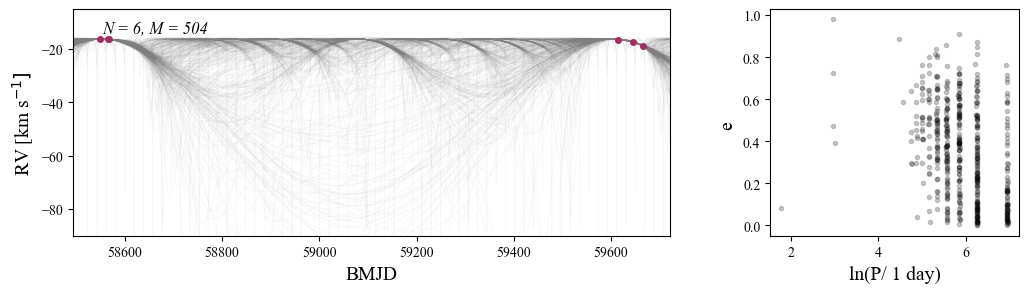

In [27]:
fig = plt.figure(figsize=(22,10))

gs = fig.add_gridspec(nrows=3, ncols=3, left=0.05, right=0.48, wspace=0.4)
f_ax1 = fig.add_subplot(gs[-1, :-1])
f_ax2 = fig.add_subplot(gs[-1,-1])

_ = tj.plot_rv_curves(samples,data=data,plot_kwargs=dict(color="tab:grey"),data_plot_kwargs=dict(color="#A52C60"),relative_to_t_ref=False,ax=f_ax1)
f_ax2.scatter(np.log(samples['P'].value), samples['e'].value,marker='.', color='k', alpha=0.2)

f_ax1.set_xlabel("BMJD",fontsize=14)
f_ax1.set_ylabel("RV [km s$^{-1}]$", fontsize=14)

f_ax2.set_xlabel("ln(P/ 1 day)",fontsize=14)
f_ax2.set_ylabel("e ",fontsize=14)

f_ax1.set_ylim(-90,-5)
f_ax1.text(0.05, 0.95, f'N = {len(t)}, M = {len(samples)}', transform=f_ax1.transAxes, fontsize = 12, verticalalignment='top', horizontalalignment='left', fontstyle = 'italic')
plt.show()

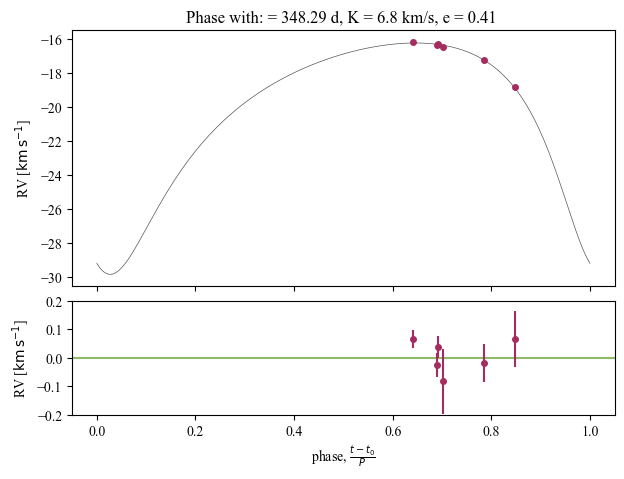

In [30]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(7, 5), gridspec_kw={"height_ratios": (1.8, 0.8), 'hspace': 0.08})

ax[0].set_title(f"Phase with: = {round(float(samples.median_period()['P'].value),2)} d, K = {round(float(samples.median_period()['K'].value),2)} km/s, e = {round(float(samples.median_period()['e'].value),2)} ")

    
_ = tj.plot_phase_fold(samples.median_period(),data=data,ax=ax[0],remove_trend = False,data_plot_kwargs=dict(color="#A52C60"))
_ = tj.plot_phase_fold(samples.median_period(), data, ax=ax[1], residual=True,data_plot_kwargs=dict(color="#A52C60"))

ax[1].axhline(0, zorder=-10, color="#73a942", alpha=0.8)
ax[1].set_ylim(-0.2, 0.2)

for ax in fig.get_axes():
    ax.label_outer()
    #ax.grid(linestyle='-', linewidth=0.1)

Hay que tener en cuenta las barras de periodos que se presentan, por ejemplo en este caso, se presentan 5 concentraciones grandes de periodos, que serían cerca de 200, 250, poco mas de 300, 500 y poco más de 1000 días, entonces algo bueno sería asegurarnos que ese mismo número de barras representativas de periodos de mantuviera en los histogramas.

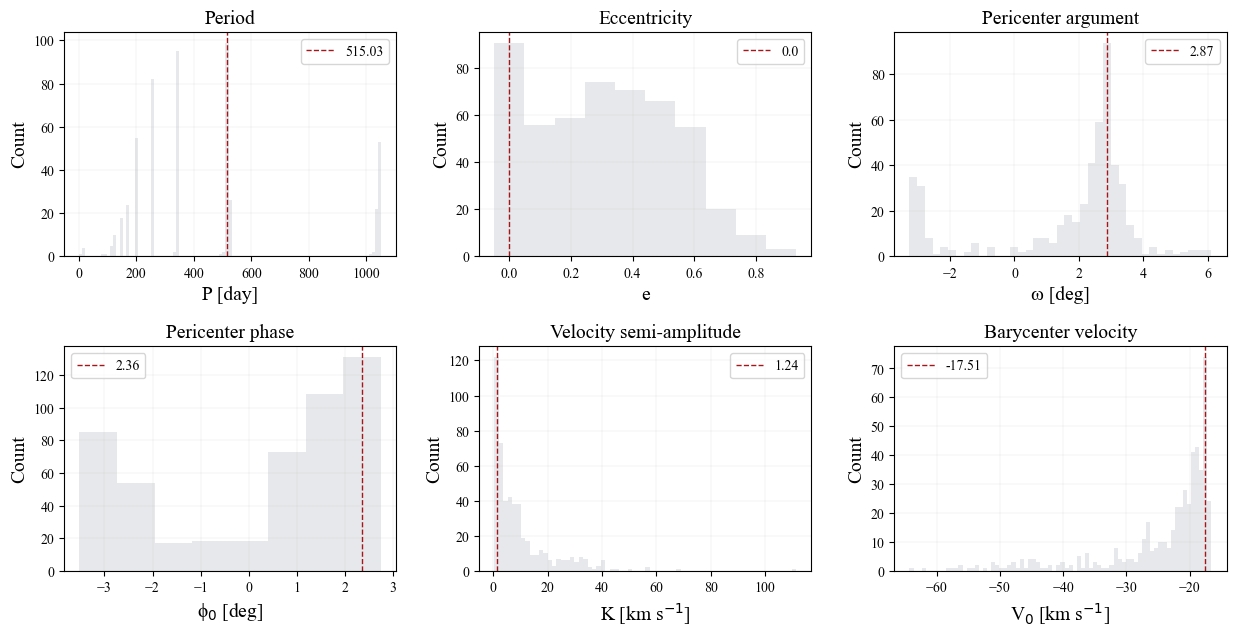

In [33]:
variables = ["P", "e", "omega", "M0", "K", "v0"]
xlabel = ["P [day]", "e", "ω [deg]", "ϕ$_0$ [deg]", "K [km s$^{-1}$]","V$_0$ [km s$^{-1}$]"]
title = ["Period","Eccentricity", "Pericenter argument", "Pericenter phase", "Velocity semi-amplitude", "Barycenter velocity"]
picos = []

fig = plt.figure(figsize=(15,7))

gs = fig.add_gridspec(2, 3, hspace=0.4, wspace=0.25)
(ax1,ax2,ax3), (ax4,ax5,ax6) = gs.subplots(sharey = False, sharex = False)

for ax,i in zip(fig.get_axes(),np.arange(len(variables))):
    ax.set_ylabel("Count", fontsize = 14)
    ax.set_xlabel(xlabel[i], fontsize = 14)
    ax.set_title(title[i], fontsize = 14)
    conteos, bins, _  =  ax.hist(samples[variables[i]], bins = "stone", histtype='stepfilled', density = False ,alpha=0.3, align = 'left', color = '#adb5bd', ec="k")
    indice_maximo = np.argmax(conteos)
    
    # Obtener el valor del pico más alto
    pico_mas_alto = bins[indice_maximo]
    picos.append(pico_mas_alto)
    # Agregar una línea vertical en el pico más alto
    ax.axvline(x=pico_mas_alto, color='#a4161a', linestyle='--', linewidth = 1, label = f"{round(pico_mas_alto,2)}")
    ax.grid(linestyle='-', linewidth=0.1)
    ax.legend()

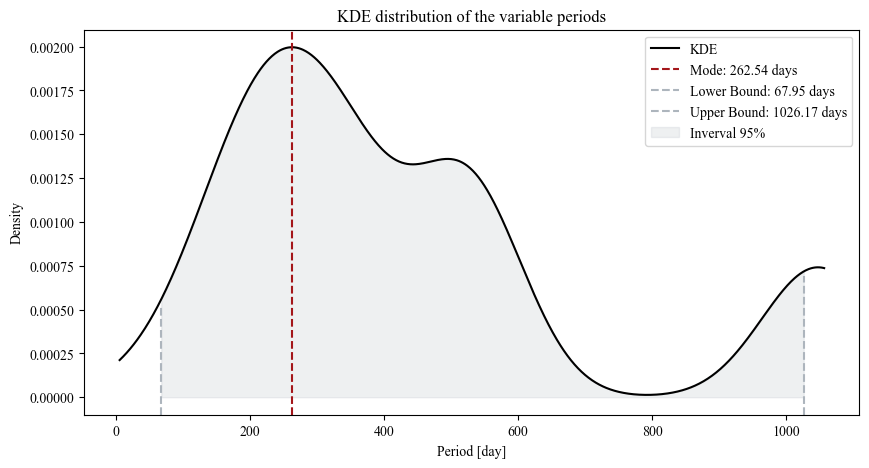

In [35]:
Periodos = samples[(samples["P"].value>=0) & (samples["P"].value<=1500)]

kde = gaussian_kde(Periodos["P"].value, bw_method='scott')  # bw_method puede ajustarse si es necesario
x_grid = np.linspace(min(Periodos["P"].value), max(Periodos["P"].value), 1000)
kde_values = kde(x_grid)
moda = x_grid[np.argmax(kde_values)]

#moda = picos[0]
cumulative_probs = np.cumsum(kde_values)
cumulative_probs /= cumulative_probs[-1]  # Normalizar para que el máximo sea 1

# Buscar los índices correspondientes al 2.5% y 97.5% alrededor de la moda
lower_bound = x_grid[np.argmax(cumulative_probs > 0.025)]
upper_bound = x_grid[np.argmax(cumulative_probs > 0.975)]

plt.figure(figsize=(10,5))
plt.plot(x_grid, kde_values, label='KDE', color = "k")
plt.axvline(moda, color='#a4161a', linestyle='--', label=f'Mode: {moda:.2f} days')
plt.axvline(lower_bound, color='#adb5bd', linestyle='--', ymin = 0, ymax=kde(lower_bound)[0]/kde_values.max(), label=f'Lower Bound: {lower_bound:.2f} days')
plt.axvline(upper_bound, color='#adb5bd', linestyle='--', ymin = 0, ymax=kde(upper_bound)[0]/kde_values.max(), label=f'Upper Bound: {upper_bound:.2f} days')
plt.fill_between(x_grid, 0, kde_values, where=(x_grid >= lower_bound) & (x_grid <= upper_bound), color='#adb5bd', alpha=0.2, label='Inverval 95%')
plt.legend()
plt.xlabel('Period [day]')
plt.ylabel('Density')
plt.title('KDE distribution of the variable periods')
plt.show()

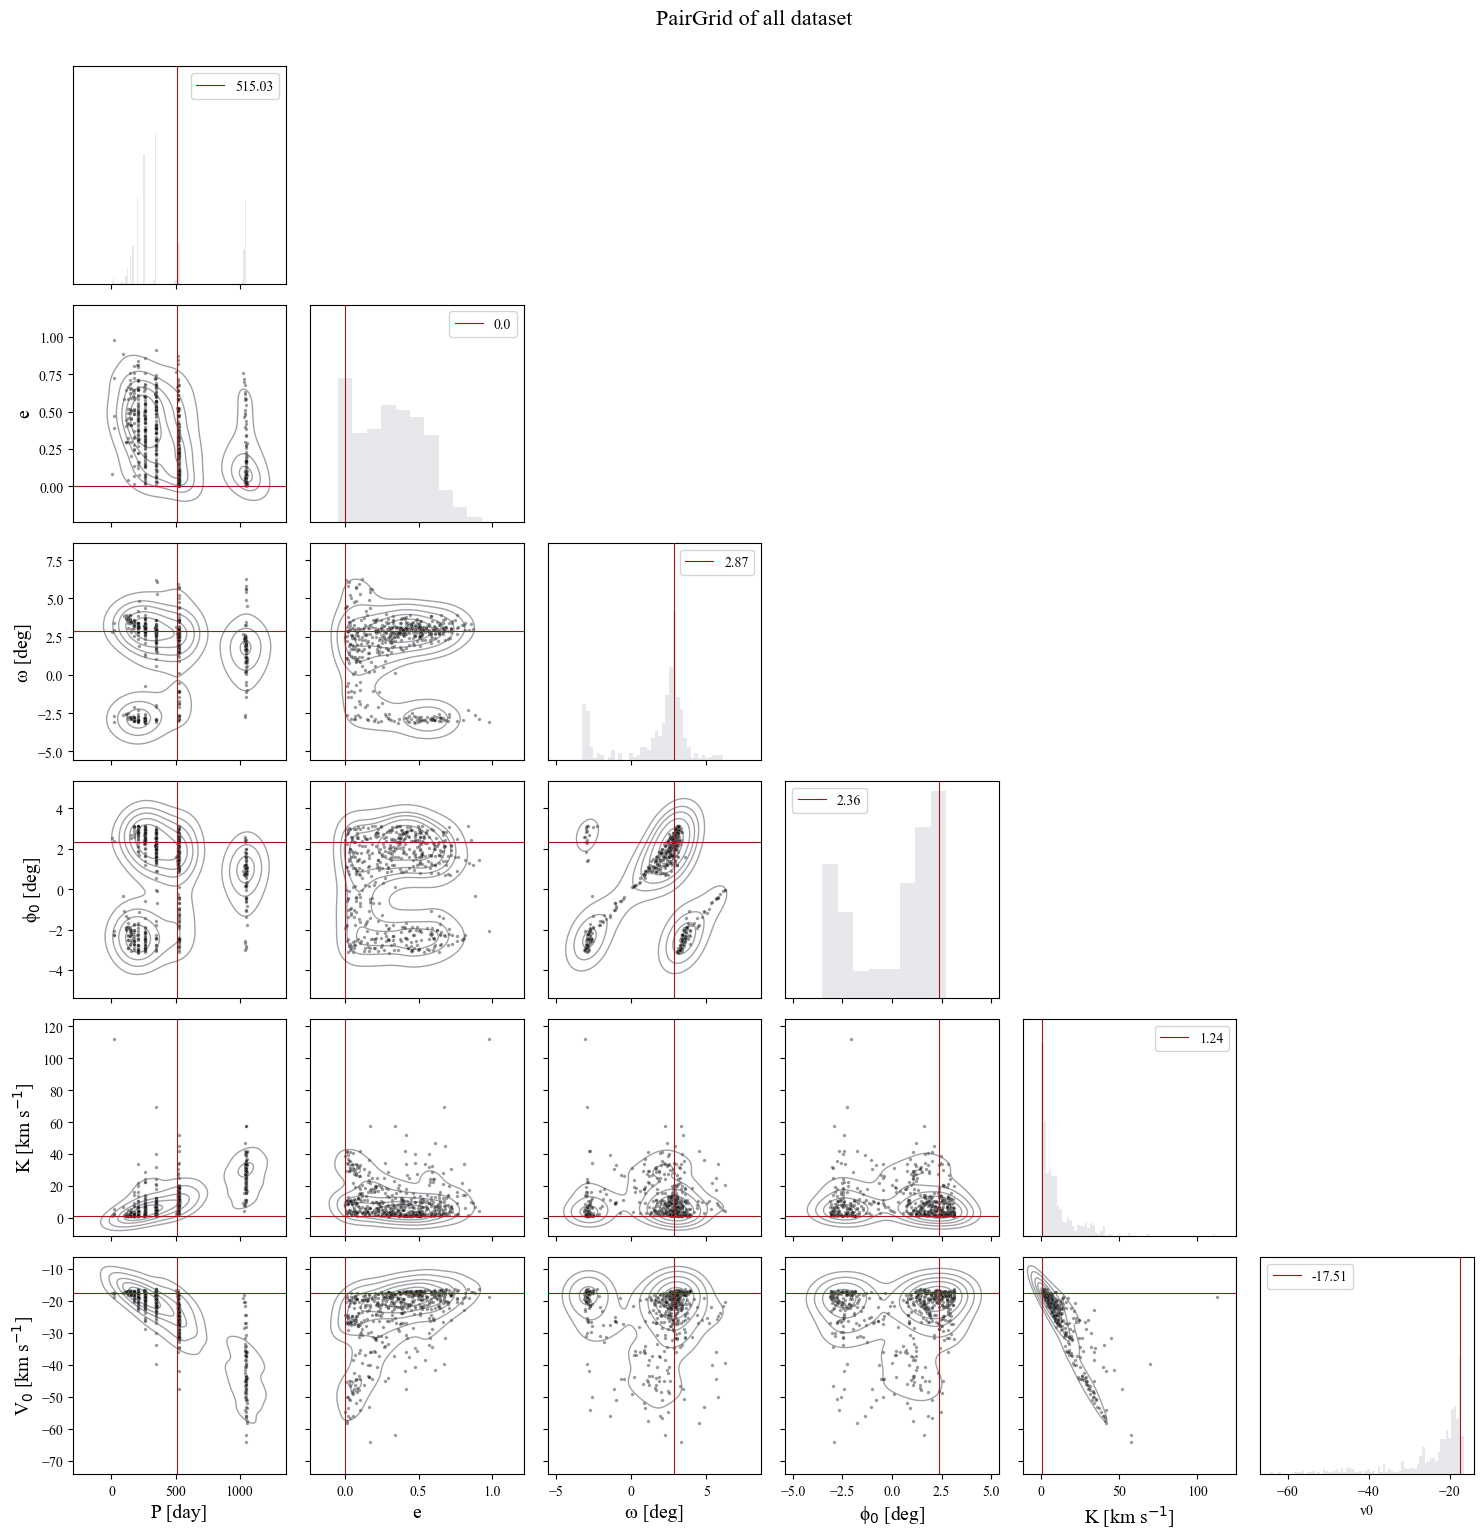

In [37]:
# Crear un gráfico de correlación utilizando pairplot
df = samples.tbl.to_pandas()
g = sns.PairGrid(df, 
            x_vars=["P", "e", "omega", "M0", "K", "v0"],
            y_vars=["P", "e", "omega", "M0", "K", "v0"],
            corner=True)                                   # No muestra las de encima de la diagonal
# Mostrar el gráfico

g.map_diag(plt.hist,  bins = "stone", histtype='stepfilled', density = False ,alpha=0.3, align = 'left', color = '#adb5bd', ec="k")             #Histogramas en la diagonal
g.map_lower(sns.kdeplot,linewidths = 1, levels=6,  color="#3F4750",thresh=.1, alpha = 0.5)             # Muestra los contornos
g.map_lower(sns.scatterplot,s = 6, alpha = 0.4, color="k")                     # Muestra los puntos

# Añadir bordes y rejillas a cada cuadrícula
for ax in g.axes.flatten():
    if ax is not None:
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['top'].set_visible(True)
        ax.grid(False)

# Agregar líneas verticales y horizontales en los gráficos de densidad fuera de la diagonal
for i, x_var in enumerate(variables):
    for j, y_var in enumerate(variables):
        if i != j:
            ax = g.axes[j, i]
            if ax is not None:
                ax.axvline(x=picos[i], color='#a4161a', linestyle='-', linewidth=0.8)
                ax.axhline(y=picos[j], color='#a4161a', linestyle='-', linewidth=0.8)
                ax.set_xlabel(xlabel[i], fontsize = 14)
                ax.set_ylabel(xlabel[j], fontsize = 14)

# Agregar líneas verticales personalizadas en las diagonales

for i in np.arange(len(g.diag_axes)):
    ax = g.diag_axes[i]
    ax.axvline(x=picos[i], color='#a4161a', linestyle='-', linewidth = 0.8, label = f"{round(picos[i],2)}")
    ax.legend()
    
ax.set_ylabel(xlabel[-1], fontsize = 14)

# Título del PairGrid
g.fig.suptitle("PairGrid of all dataset", y=1.02, fontsize = 16)
plt.show()

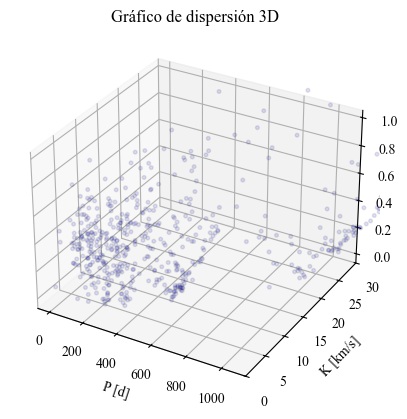

In [38]:
# Datos de muestra
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')

ax.set_xlabel("P [d]")
ax.set_ylabel("K [km/s]")
ax.set_zlabel("e")
ax.set_ylim(0,30)
plt.title("Gráfico de dispersión 3D")

# Gráfico de dispersión 3D
ax.scatter(samples["P"], samples["K"], samples["e"],marker="o", s=7, color = "b", alpha=0.12, ec='#212325')

plt.show()

In [39]:
len(bins)

75

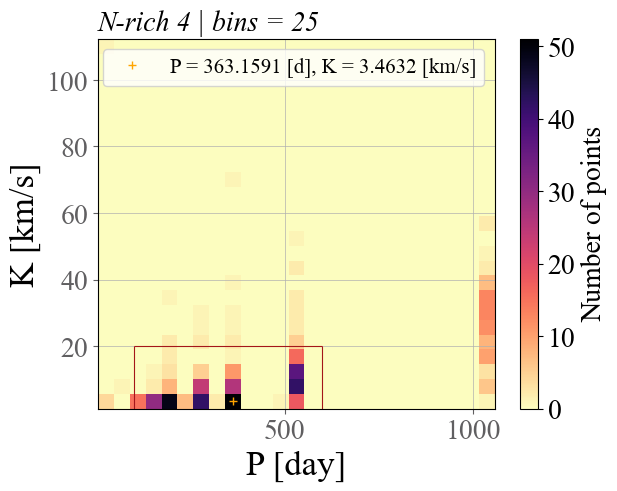

Coordenadas del valor más significativo:
x = 363.1591370934094
y = 3.4631873519826906


In [40]:
bin = 25

# Calcula el histograma bidimensional
hist, x_edges, y_edges = np.histogram2d(x=samples['P'].value, y=samples['K'].to(u.km/u.s).value, bins=bin)

# Encuentra las coordenadas del bin con el valor máximo en el histograma
max_index = np.unravel_index(np.argmax(hist), hist.shape)
x_max_density = (x_edges[max_index[0]] + x_edges[max_index[0] + 1]) / 2
y_max_density = (y_edges[max_index[1]] + y_edges[max_index[1] + 1]) / 2

# Grafica el histograma
fig, ax = plt.subplots()
h = ax.hist2d(x=samples['P'].value, y=samples['K'].to(u.km/u.s).value, bins=bin, cmap = "magma_r")
cbar = fig.colorbar(h[3], ax=ax)
cbar.ax.tick_params(labelsize=20)  # Aumentar tamaño de los valores de la barra de color
cbar.set_label("Number of points", fontsize=20)  # Ajustar tamaño de la etiqueta

ax.plot(x_max_density, y_max_density, "+", color="orange", label=f"P = {round(x_max_density, 4)} [d], K = {round(y_max_density, 4)} [km/s]")
ax.set_xlabel("P [day]", fontsize = 25)
ax.set_ylabel("K [km/s]", fontsize = 25)

xmin = 100
xmax = 600
ymin = 0
ymax = 20

ax.vlines(x=xmin, ymin = ymin, ymax = ymax, color='#a4161a', linestyle='-', linewidth=0.8)
ax.vlines(x=xmax, ymin = ymin, ymax = ymax, color='#a4161a', linestyle='-', linewidth=0.8)

ax.hlines(y=ymin ,xmin = xmin, xmax = xmax, color='#a4161a', linestyle='-', linewidth=0.8)
ax.hlines(y=ymax, xmin = xmin, xmax = xmax, color='#a4161a', linestyle='-', linewidth=0.8)

plt.text(0, 1.08, f'N-rich 4 | bins = {bin}', transform=ax.transAxes, fontsize = 20, verticalalignment='top', horizontalalignment='left', fontstyle = 'italic')
ax.tick_params(axis='both', labelsize=20, colors = '#605f61')  # Aumenta el tamaño de los números en ambos ejes

plt.grid(linestyle='-', linewidth=0.5)
plt.legend(fontsize=15)

plt.savefig("Corr_Nrich4.png", dpi=300, bbox_inches="tight")
plt.show()

print("Coordenadas del valor más significativo:")
print("x =", x_max_density)
print("y =", y_max_density)

In [41]:
mask_P = (samples["P"].value>=xmin) & (samples["P"].value<=xmax)

Filtrado = samples[mask_P]
mask_K = (Filtrado["K"].value>=ymin) & (Filtrado["K"].value<=ymax)

Filtrado = Filtrado[mask_K]

In [42]:
Filtrado

<JokerSamples [P, e, omega, M0, s, K, v0] (397 samples)>

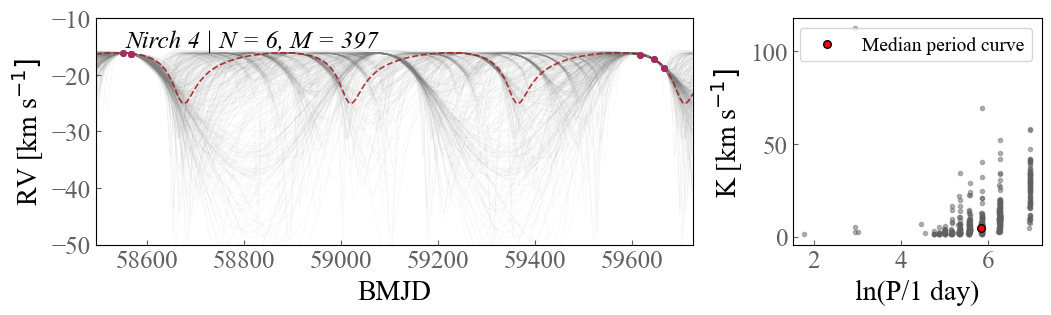

In [43]:
fig = plt.figure(figsize=(22,10))

gs = fig.add_gridspec(nrows=3, ncols=3, left=0.05, right=0.48, wspace=0.4)
f_ax1 = fig.add_subplot(gs[-1, :-1])
f_ax2 = fig.add_subplot(gs[-1,-1])

_ = tj.plot_rv_curves(Filtrado,data=data,plot_kwargs=dict(color="tab:grey"),data_plot_kwargs=dict(color="#A52C60"),relative_to_t_ref=False,ax=f_ax1)
_ = tj.plot_rv_curves(Filtrado.median_period(),data=data,plot_kwargs=dict(linestyle = "--", linewidth = 1.2,color="#a4161a"),data_plot_kwargs=dict(color="#A52C60"),relative_to_t_ref=False,ax=f_ax1, add_labels=True)
f_ax2.scatter(np.log(samples['P'].value), samples['K'].value,marker='.', color='#605f61', alpha=0.45)

f_ax2.scatter(np.log(Filtrado.median_period()["P"].value), 
              Filtrado.median_period()["K"], 
              color="red", edgecolors="black", s=30, label="Median period curve")

f_ax1.set_xlabel("BMJD",fontsize=20)
f_ax1.set_ylabel("RV [km s$^{-1}]$", fontsize=20)

f_ax2.set_xlabel("ln(P/1 day)",fontsize=20)
f_ax2.set_ylabel("K [km s$^{-1}]$ ",fontsize=20)

f_ax1.set_ylim(-50,-10)
f_ax1.tick_params(axis='both', labelsize=18, direction="in", colors="#605f61")  # Aumenta el tamaño de los números en ambos ejes
f_ax2.tick_params(axis='both', labelsize=18,  direction="in", colors = "#605f61")  # Aumenta el tamaño de los números en ambos ejes

f_ax1.text(0.05, 0.95, f'Nirch 4 | N = {len(t)}, M = {len(Filtrado)}', transform=f_ax1.transAxes, fontsize = 18, verticalalignment='top', horizontalalignment='left', fontstyle = 'italic')
f_ax2.legend(fontsize = 14)
# Guardar el gráfico en alta calidad
plt.savefig("Filtrado_Nrich4.png", dpi=300, bbox_inches="tight")

plt.show()

In [44]:
Filtrado.median_period()["P"],Filtrado.median_period()["K"]

(<Quantity [344.27199366] d>, <Quantity [4.49302326] km / s>)

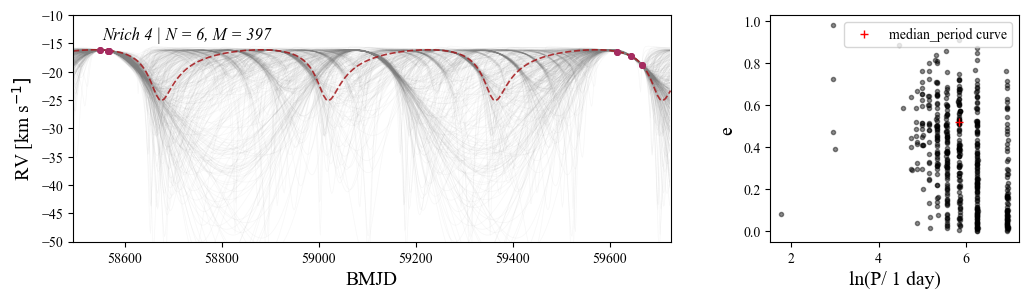

In [45]:
fig = plt.figure(figsize=(22,10))

gs = fig.add_gridspec(nrows=3, ncols=3, left=0.05, right=0.48, wspace=0.4)
f_ax1 = fig.add_subplot(gs[-1, :-1])
f_ax2 = fig.add_subplot(gs[-1,-1])

_ = tj.plot_rv_curves(Filtrado,data=data,plot_kwargs=dict(color="tab:grey"),data_plot_kwargs=dict(color="#A52C60"),relative_to_t_ref=False,ax=f_ax1)
_ = tj.plot_rv_curves(Filtrado.median_period(),data=data,plot_kwargs=dict(linestyle = "--", linewidth = 1.2,color="#a4161a"),data_plot_kwargs=dict(color="#A52C60"),relative_to_t_ref=False,ax=f_ax1, add_labels=True)
f_ax2.scatter(np.log(samples['P'].value), samples['e'].value,marker='.', color='k', alpha=0.45)

# f_ax2.plot(np.log(x_max_density),picos[1], "+", color = "orange")
f_ax2.plot(np.log(Filtrado.median_period()["P"].value),Filtrado.median_period()["e"], "+", color = "red" ,label = 'median_period curve'  )

f_ax1.set_xlabel("BMJD",fontsize=14)
f_ax1.set_ylabel("RV [km s$^{-1}]$", fontsize=14)

f_ax2.set_xlabel("ln(P/ 1 day)",fontsize=14)
f_ax2.set_ylabel("e ",fontsize=14)

f_ax1.set_ylim(-50,-10)
f_ax1.text(0.05, 0.95, f'Nrich 4 | N = {len(t)}, M = {len(Filtrado)}', transform=f_ax1.transAxes, fontsize = 12, verticalalignment='top', horizontalalignment='left', fontstyle = 'italic')
f_ax2.legend(fontsize = 10)
plt.show()

In [46]:
Filtrado.median_period()["P"],Filtrado.median_period()["e"]

(<Quantity [344.27199366] d>, <Quantity [0.51870875]>)

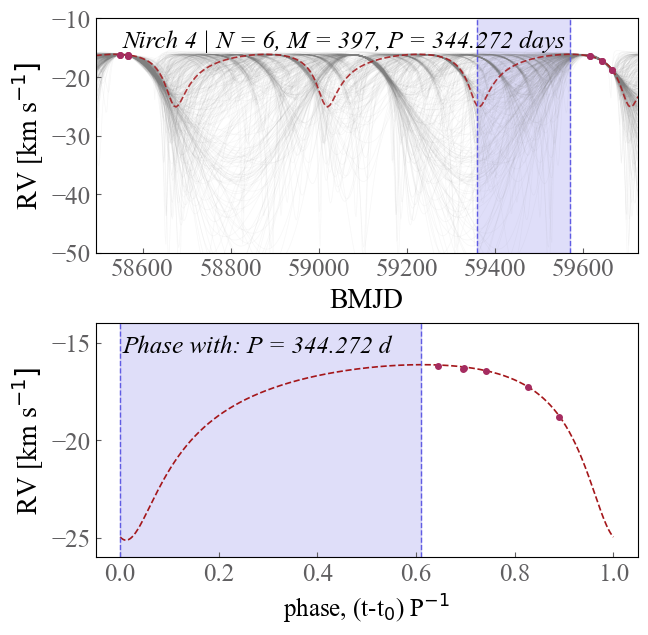

In [47]:
fig, ax = plt.subplots(2, 1, sharex=False, figsize=(7, 7), gridspec_kw={"height_ratios": (1.8,1.8), 'hspace': 0.3})

_ = tj.plot_rv_curves(Filtrado,data=data,plot_kwargs=dict(color="tab:grey"),data_plot_kwargs=dict(color="#A52C60"),relative_to_t_ref=False,ax=ax[0])
_ = tj.plot_rv_curves(Filtrado.median_period(),data=data,plot_kwargs=dict(linestyle = "--", linewidth = 1.2,color="#a4161a"),data_plot_kwargs=dict(color="#A52C60"),relative_to_t_ref=False,ax=ax[0], add_labels=True)

    
_ = tj.plot_phase_fold(Filtrado.median_period(), data=data, plot_kwargs=dict(linestyle = "--", linewidth = 1.2,color="#a4161a"),ax=ax[1],remove_trend = False, data_plot_kwargs=dict(color="#A52C60"))
# _ = tj.plot_phase_fold(orbita, data, ax=ax[2], residual=True, data_plot_kwargs=dict(color="#A52C60"))
ax[0].set_ylim(-50,-10)
ax[0].text(0.05,0.95, f"Nirch 4 | N = {len(t)}, M = {len(Filtrado)}, P = {round(Filtrado.median_period()['P'][0].value,3)} days", transform=ax[0].transAxes, fontsize = 18, verticalalignment='top', horizontalalignment='left', fontstyle = 'italic')
ax[1].text(0.05,0.95,f"Phase with: P = {round(float(Filtrado.median_period()['P'][0].value),3)} d", transform=ax[1].transAxes, fontsize = 18, verticalalignment='top', horizontalalignment='left', fontstyle = 'italic')
# ax[2].axhline(0, zorder=-10, color="#73a942", alpha=0.8)
fecha1 = 59360
fecha2 = 59570
# fecha3 = 59450
# fecha4 = 59600
ax[0].axvline(fecha1, color = "#605ce3", linewidth = 1, linestyle = "dashed");

ax[0].axvline(fecha2, color = "#605ce3", linewidth = 1, linestyle = "dashed");
ax[0].axvspan(fecha1, fecha2, color='#605ce3', alpha=0.2)

# ax[0].axvline(fecha3, color = "#e37d5c", linewidth = 1, linestyle = "dashed");
# ax[0].axvline(fecha4, color = "#e37d5c", linewidth = 1, linestyle = "dashed");
# ax[0].axvspan(fecha3, fecha4, color='#e37d5c', alpha=0.2)

x1 = (fecha1-59360)/Filtrado.median_period()['P'][0].value
x2 = (fecha2-59360)/Filtrado.median_period()['P'][0].value
# x3 = (fecha3-59400)/orbita["P"][0].value
# x4 = (fecha4-59400)/orbita["P"][0].value
ax[1].axvspan(x1, x2, color='#605ce3', alpha=0.2)
ax[1].axvline(x1, color = "#605ce3", linewidth = 1, linestyle = "dashed");
ax[1].axvline(x2, color = "#605ce3", linewidth = 1, linestyle = "dashed");
# ax[1].axvspan(x3, x4, color='#e37d5c', alpha=0.2)
# ax[1].axvline(x3, color = "#e37d5c", linewidth = 1, linestyle = "dashed");
# ax[1].axvline(x4, color = "#e37d5c", linewidth = 1, linestyle = "dashed");
ax[0].set_xlabel("BMJD",fontsize=20)
ax[0].set_ylabel("RV [km s$^{-1}]$", fontsize=20)

ax[1].set_xlabel("phase, (t-t$_0$) P$^{-1}$",fontsize=18)
ax[1].set_ylabel("RV [km s$^{-1}]$", fontsize=20)

ax[0].tick_params(axis='both', labelsize=18, direction="in", colors="#605f61")  # Aumenta el tamaño de los números en ambos ejes
ax[1].tick_params(axis='both', labelsize=18,  direction="in", colors = "#605f61")  # Aumenta el tamaño de los números en ambos ejes
ax[1].set_ylim(-26, -14)

plt.savefig("Fechas_Nrich4.png", dpi=300, bbox_inches="tight")


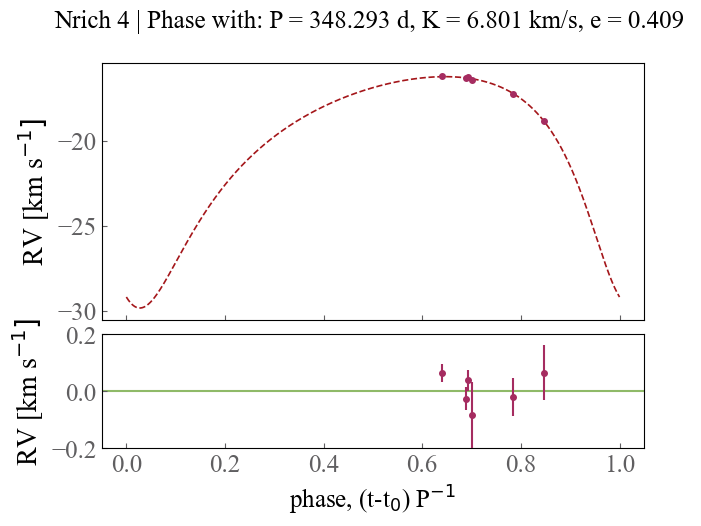

In [61]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(7, 5), gridspec_kw={"height_ratios": (1.8, 0.8), 'hspace': 0.08})

ax[0].set_title(f"Nrich 4 | Phase with: P = {round(float(samples.median_period()['P'].value),3)} d, K = {round(float(samples.median_period()['K'].value),3)} km/s, e = {round(float(samples.median_period()['e'].value),3)} \n",fontsize = 18)

    
_ = tj.plot_phase_fold(samples.median_period(), data=data,plot_kwargs=dict(linestyle = "--", linewidth = 1.2,color="#a4161a"),ax=ax[0],remove_trend = False, data_plot_kwargs=dict(color="#A52C60"))
_ = tj.plot_phase_fold(samples.median_period(), data, ax=ax[1], residual=True, data_plot_kwargs=dict(color="#A52C60"))

ax[1].axhline(0, zorder=-10, color="#73a942", alpha=0.8)
ax[1].set_ylim(-0.2, 0.2)
ax[1].set_xlabel("phase, (t-t$_0$) P$^{-1}$",fontsize=18)
ax[0].set_ylabel("RV [km s$^{-1}]$", fontsize=20)
ax[1].set_ylabel("RV [km s$^{-1}]$", fontsize=20)
ax[0].tick_params(axis='both', labelsize=18, direction="in", colors="#605f61")  # Aumenta el tamaño de los números en ambos ejes
ax[1].tick_params(axis='both', labelsize=18,  direction="in", colors = "#605f61")  # Aumenta el tamaño de los números en ambos ejes

for ax in fig.get_axes():
    ax.label_outer()

    #ax.grid(linestyle='-', linewidth=0.1)

plt.savefig("Phase_Nrich4.png", dpi=300, bbox_inches="tight")

In [63]:
f_c1 = fecha1+4*Filtrado.median_period()['P'][0].value
print(f"La posible fecha de observación para P = {Filtrado.median_period()['P'][0].value} es: {f_c1} = {BMJD_to_hms(f_c1)}")
f_c2 = fecha2+4*Filtrado.median_period()['P'][0].value
print(f"La posible fecha de observación para P = {Filtrado.median_period()['P'][0].value} es: {f_c1} = {BMJD_to_hms(f_c2)}")

La posible fecha de observación para P = 344.2719936635378 es: 60737.087974654154 = 2025-03-03 02:06:41.010
La posible fecha de observación para P = 344.2719936635378 es: 60737.087974654154 = 2025-09-29 02:06:41.010


In [65]:
mask_P_200 = (samples["P"].value>=200) & (samples["P"].value<=220)
Filtrado_200 = samples[mask_P_200]
mask_K_200 = (Filtrado_200["K"].value>=ymin) & (Filtrado_200["K"].value<=60)
Filtrado_200 = Filtrado_200[mask_K_200]

mask_P_250 = (samples["P"].value>=240) & (samples["P"].value<=280)
Filtrado_250 = samples[mask_P_250]
mask_K_250 = (Filtrado_250["K"].value>=ymin) & (Filtrado_250["K"].value<=60)
Filtrado_250 = Filtrado_250[mask_K_250]


mask_P_300 = (samples["P"].value>=330) & (samples["P"].value<=360)
Filtrado_300 = samples[mask_P_300]
mask_K_300 = (Filtrado_300["K"].value>=ymin) & (Filtrado_300["K"].value<=60)
Filtrado_300 = Filtrado_300[mask_K_300]

mask_P_500 = (samples["P"].value>=500) & (samples["P"].value<=540)
Filtrado_500 = samples[mask_P_500]
mask_K_500 = (Filtrado_500["K"].value>=ymin) & (Filtrado_500["K"].value<=60)
Filtrado_500 = Filtrado_500[mask_K_500]

mask_P_1000 = (samples["P"].value>=1000) & (samples["P"].value<=1100)
Filtrado_1000 = samples[mask_P_1000]
mask_K_1000 = (Filtrado_1000["K"].value>=ymin) & (Filtrado_1000["K"].value<=60)
Filtrado_1000 = Filtrado_1000[mask_K_1000]

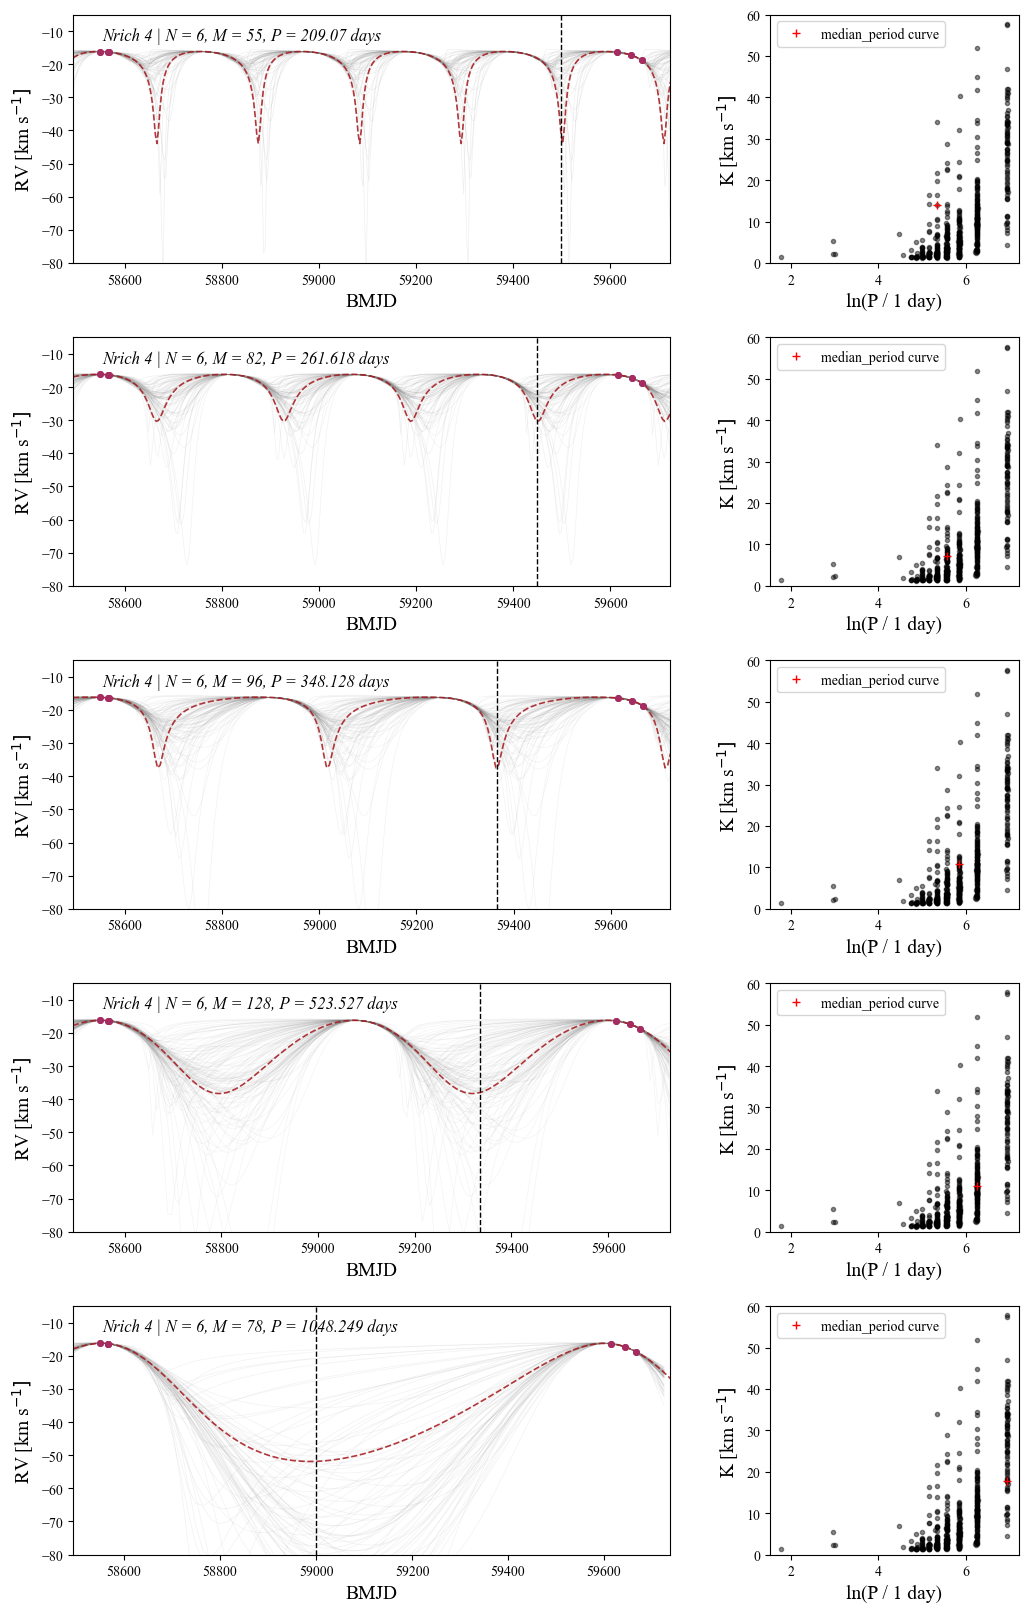

In [67]:
fig = plt.figure(figsize=(22,20))

gs = fig.add_gridspec(nrows=5, ncols=3, left=0.05, right=0.48, wspace=0.4, hspace = 0.3)
f_ax0 = fig.add_subplot(gs[0, :-1])
f_ax1 = fig.add_subplot(gs[0,-1])

f_ax2 = fig.add_subplot(gs[1, :-1])
f_ax3= fig.add_subplot(gs[1,-1])

f_ax4 = fig.add_subplot(gs[2, :-1])
f_ax5 = fig.add_subplot(gs[2,-1])

f_ax6 = fig.add_subplot(gs[3, :-1])
f_ax7 = fig.add_subplot(gs[3,-1])

f_ax8 = fig.add_subplot(gs[4, :-1])
f_ax9 = fig.add_subplot(gs[4,-1])

axs = [f_ax0,f_ax1,f_ax2,f_ax3,f_ax4,f_ax5,f_ax6,f_ax7,f_ax8,f_ax9]
Filtrados_all = [Filtrado_200,Filtrado_250,Filtrado_300,Filtrado_500,Filtrado_1000]

for i,j in zip(np.arange(5),np.arange(len(Filtrados_all))):
    _ = tj.plot_rv_curves(Filtrados_all[j],data=data,plot_kwargs=dict(color="tab:grey"),data_plot_kwargs=dict(color="#A52C60"),relative_to_t_ref=False,ax=axs[i*2])
    _ = tj.plot_rv_curves(Filtrados_all[j].median_period(),data=data,plot_kwargs=dict(linestyle = "--", linewidth = 1.2,color="#a4161a"),data_plot_kwargs=dict(color="#A52C60"),relative_to_t_ref=False,ax=axs[i*2], add_labels=True)
    axs[i*2+1].scatter(np.log(samples['P'].value), samples['K'].value,marker='.', color='k', alpha=0.45)
    axs[i*2+1].plot(np.log(Filtrados_all[j].median_period()["P"].value),Filtrados_all[j].median_period()["K"].value, "+", color = "red", label = 'median_period curve' )

axs[0].axvline(59500, color = "k", linewidth = 1, linestyle = "dashed");
# axs[0].axvline(59500+Filtrados_all[0].median_period()["P"].value, color = "b", linewidth = 1, linestyle = "dashed");
axs[2].axvline(59450, color = "k", linewidth = 1, linestyle = "dashed");
# axs[2].axvline(59450+Filtrados_all[1].median_period()["P"].value, color = "b", linewidth = 1, linestyle = "dashed");
axs[4].axvline(59365, color = "k", linewidth = 1, linestyle = "dashed");
# axs[4].axvline(59365+Filtrados_all[2].median_period()["P"].value, color = "b", linewidth = 1, linestyle = "dashed");
axs[6].axvline(59335, color = "k", linewidth = 1, linestyle = "dashed");
# axs[6].axvline(59335+Filtrados_all[3].median_period()["P"].value, color = "b", linewidth = 1, linestyle = "dashed");
axs[8].axvline(59000, color = "k", linewidth = 1, linestyle = "dashed");
# axs[8].axvline(59000+Filtrados_all[4].median_period()["P"].value, color = "b", linewidth = 1, linestyle = "dashed");

for i,j in zip(np.arange(5),Filtrados_all):
    
    
    axs[i*2].set_xlabel("BMJD",fontsize=14)
    axs[i*2].set_ylabel("RV [km s$^{-1}]$", fontsize=14)
    
    axs[i*2+1].set_xlabel("ln(P / 1 day)",fontsize=14)
    axs[i*2+1].set_ylabel("K [km s$^{-1}]$ ",fontsize=14)

    axs[i*2].set_ylim(-80,-5)
    axs[i*2+1].set_ylim(0,60)
    axs[i*2].text(0.05, 0.95, f'Nrich 4 | N = {len(t)}, M = {len(j)}, P = {round(Filtrados_all[i].median_period()["P"][0].value,3)} days', transform=axs[i*2].transAxes, fontsize = 12, verticalalignment='top', horizontalalignment='left', fontstyle = 'italic')
    axs[i*2+1].legend(fontsize = 10)
plt.show()

In [68]:
f_c1 = 59500+6*Filtrados_all[0].median_period()["P"].value
print(f"La posible fecha de observación para P = {Filtrados_all[0].median_period()['P']} es: {f_c1} = {BMJD_to_hms(f_c1)}")
f_c2 = 59450+5*Filtrados_all[1].median_period()["P"].value
print(f"La posible fecha de observación para P = {Filtrados_all[1].median_period()['P']} es: {f_c2}  = {BMJD_to_hms(f_c2)}")
f_c3 = 59365+4*Filtrados_all[2].median_period()["P"].value
print(f"La posible fecha de observación para P = {Filtrados_all[2].median_period()['P']} es: {f_c3}  = {BMJD_to_hms(f_c3)}")
f_c4 = 59335+3*Filtrados_all[3].median_period()["P"].value
print(f"La posible fecha de observación para P = {Filtrados_all[3].median_period()['P']} es: {f_c4}  = {BMJD_to_hms(f_c4)}")
f_c5 = 59000+2*Filtrados_all[4].median_period()["P"].value
print(f"La posible fecha de observación para P = {Filtrados_all[4].median_period()['P']} es: {f_c5}  = {BMJD_to_hms(f_c5)}")

La posible fecha de observación para P = [209.06954265] d es: [60754.41725588] = ['2025-03-20 10:00:50.908']
La posible fecha de observación para P = [261.61821491] d es: [60758.09107454]  = ['2025-03-24 02:11:08.840']
La posible fecha de observación para P = [348.12847878] d es: [60757.51391513]  = ['2025-03-23 12:20:02.267']
La posible fecha de observación para P = [523.52709753] d es: [60905.58129259]  = ['2025-08-18 13:57:03.680']
La posible fecha de observación para P = [1048.24934803] d es: [61096.49869606]  = ['2026-02-25 11:58:07.339']


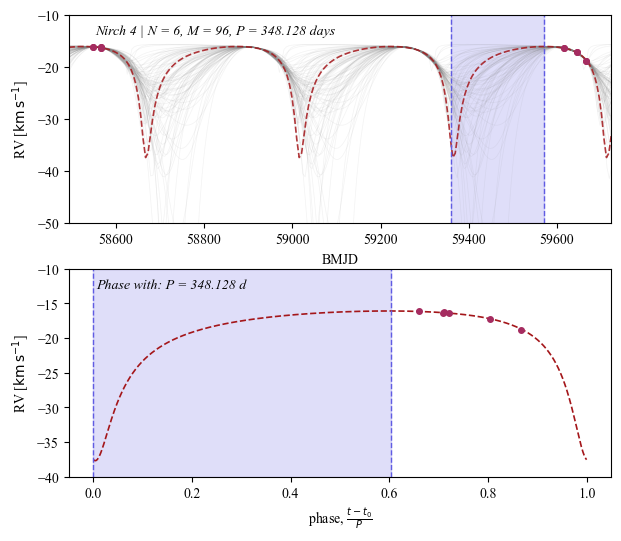

In [71]:
fig, ax = plt.subplots(2, 1, sharex=False, figsize=(7, 6), gridspec_kw={"height_ratios": (1.8,1.8), 'hspace': 0.22})

_ = tj.plot_rv_curves(Filtrados_all[2],data=data,plot_kwargs=dict(color="tab:grey"),data_plot_kwargs=dict(color="#A52C60"),relative_to_t_ref=False,ax=ax[0])
_ = tj.plot_rv_curves(Filtrados_all[2].median_period(),data=data,plot_kwargs=dict(linestyle = "--", linewidth = 1.2,color="#a4161a"),data_plot_kwargs=dict(color="#A52C60"),relative_to_t_ref=False,ax=ax[0], add_labels=True)

    
_ = tj.plot_phase_fold(Filtrados_all[2].median_period(), data=data, plot_kwargs=dict(linestyle = "--", linewidth = 1.2,color="#a4161a"),ax=ax[1],remove_trend = False, data_plot_kwargs=dict(color="#A52C60"))
# _ = tj.plot_phase_fold(orbita, data, ax=ax[2], residual=True, data_plot_kwargs=dict(color="#A52C60"))
ax[0].set_ylim(-50,-10)
ax[1].set_ylim(-40,-10)

ax[0].text(0.05,0.95, f"Nirch 4 | N = {len(t)}, M = {len(Filtrados_all[2])}, P = {round(Filtrados_all[2].median_period()['P'][0].value,3)} days", transform=ax[0].transAxes, fontsize = 10, verticalalignment='top', horizontalalignment='left', fontstyle = 'italic')
ax[1].text(0.05,0.95,f"Phase with: P = {round(float(Filtrados_all[2].median_period()['P'][0].value),3)} d", transform=ax[1].transAxes, fontsize = 10, verticalalignment='top', horizontalalignment='left', fontstyle = 'italic')
# ax[2].axhline(0, zorder=-10, color="#73a942", alpha=0.8)
# ax[2].set_ylim(-0.5, 0.5)
fecha1 = 59360
fecha2 = 59570
# fecha3 = 59450
# fecha4 = 59600
ax[0].axvline(fecha1, color = "#605ce3", linewidth = 1, linestyle = "dashed");

ax[0].axvline(fecha2, color = "#605ce3", linewidth = 1, linestyle = "dashed");
ax[0].axvspan(fecha1, fecha2, color='#605ce3', alpha=0.2)

# ax[0].axvline(fecha3, color = "#e37d5c", linewidth = 1, linestyle = "dashed");
# ax[0].axvline(fecha4, color = "#e37d5c", linewidth = 1, linestyle = "dashed");
# ax[0].axvspan(fecha3, fecha4, color='#e37d5c', alpha=0.2)

x1 = (fecha1-59360)/Filtrados_all[2].median_period()['P'][0].value
x2 = (fecha2-59360)/Filtrados_all[2].median_period()['P'][0].value
# x3 = (fecha3-59400)/orbita["P"][0].value
# x4 = (fecha4-59400)/orbita["P"][0].value
ax[1].axvspan(x1, x2, color='#605ce3', alpha=0.2)
ax[1].axvline(x1, color = "#605ce3", linewidth = 1, linestyle = "dashed");
ax[1].axvline(x2, color = "#605ce3", linewidth = 1, linestyle = "dashed");
# ax[1].axvspan(x3, x4, color='#e37d5c', alpha=0.2)
# ax[1].axvline(x3, color = "#e37d5c", linewidth = 1, linestyle = "dashed");
# ax[1].axvline(x4, color = "#e37d5c", linewidth = 1, linestyle = "dashed");


In [73]:
f_c1 = fecha1+4*Filtrado.median_period()['P'][0].value
print(f"La posible fecha de observación para P = {Filtrado.median_period()['P'][0].value} es: {f_c1} = {BMJD_to_hms(f_c1)}")
f_c2 = fecha2+4*Filtrado.median_period()['P'][0].value
print(f"La posible fecha de observación para P = {Filtrado.median_period()['P'][0].value} es: {f_c1} = {BMJD_to_hms(f_c2)}")

La posible fecha de observación para P = 344.2719936635378 es: 60737.087974654154 = 2025-03-03 02:06:41.010
La posible fecha de observación para P = 344.2719936635378 es: 60737.087974654154 = 2025-09-29 02:06:41.010


#### Función de masa binaria
$$f(M) = \frac{M_2 \sin^3(i)}{(1+q)^2} = \frac{PK_1^3 (1-e^2)^{3/2}}{2\pi G}$$

Con $q = \frac{M_1}{M_2}$

In [76]:
# En nuestro caso
def Calculo_Masa(P,K,e):
    P = float(P.value)*u.day
    e = float(e)
    K = float(K.to("m/s").value)*u.m/u.s
    
    print("P =",P)
    print("e =",e)
    print("K =",K)
    
    def f(P,e,K):
        G = 6.67430e-11*(u.m)**3*1/u.kg * 1/u.s**2
        f = (P*K**3*(1-e**2)**(3/2))/(2*np.pi*G)
        f = f.cgs
        f = (f/(1.989e+33*u.g)*u.M_sun)
        return f
    
    # Función de masa
    f_value = f(P,e,K)
    
    
    M1 = 0.8*u.M_sun
    sini =  1
    
    # Ejemplo de uso
    def resolver_ecuacion_cubica(a, b, c, d):
        coeficientes = [a, b, c, d]
        raices = np.roots(coeficientes)
        return raices
        
    a = (sini)**3
    b = -f_value.value
    c = -2*M1.value*f_value.value
    d = -M1.value**2*f_value.value
    
    raices = resolver_ecuacion_cubica(a, b, c, d)
    print("Las raíces de la ecuación son:", raices)
    
    M2 = raices[0].real*u.M_sun
    M_jupiter = 1.898e27*u.kg
    print("La masa del objeto en M_Sun, M2 = ",M2)
    print("La masa del objeto en kg, M2 = ",M2.to("kg"))
    print("La masa del objeto en M_J, M2 = ",M2.to("M_jup"))
    print("La masa del objeto en M_E, M2 = ",M2.to("M_earth"))
    return M2

In [78]:
M2 = Calculo_Masa(Filtrado.median_period()["P"],Filtrado.median_period()["K"],Filtrado.median_period()["e"])

P = 344.2719936635378 d
e = 0.5187087532594908
K = 4493.023263406411 m / s
Las raíces de la ecuación son: [ 0.11956374+0.j         -0.05877121+0.08582334j -0.05877121-0.08582334j]
La masa del objeto en M_Sun, M2 =  0.1195637353726815 solMass
La masa del objeto en kg, M2 =  2.377417115925696e+29 kg
La masa del objeto en M_J, M2 =  125.25084598041221 jupiterMass
La masa del objeto en M_E, M2 =  39808.27680258944 earthMass


Las **enanas marrones** son objetos subestelares que tienen más masa que los planetas gigantes gaseosos más grandes , pero menos que las estrellas menos masivas de la secuencia principal. Su masa es aproximadamente de $13 - 80$ veces la de Júpiter ( $M_J$ ) 

In [81]:
M2

<Quantity 0.11956374 solMass>

In [83]:
def f(P,e,K):
        G = 6.67430e-11*(u.m)**3*1/u.kg * 1/u.s**2
        f = (P*K**3*(1-e**2)**(3/2))/(2*np.pi*G)
        f = f.cgs
        f = (f/(1.989e+33*u.g)*u.M_sun)
        return f
M1 = 0.8*u.M_sun
sini =  1

In [85]:
def resolver_ecuacion_cubica(a, b, c, d):
        coeficientes = [a, b, c, d]
        raices = np.roots(coeficientes)
        return raices

In [87]:
P_all = Filtrado["P"]
e_all = Filtrado["e"]
K_all = Filtrado["K"].to(u.m/u.s)

# Función de masa
f_value_all = f(P_all,e_all,K_all)
f_value_all

<Quantity [1.46692277e-04, 2.37925940e-04, 5.21406764e-03, 1.77101341e-04,
           1.09312691e-03, 3.06313339e-05, 5.25984009e-04, 8.13734554e-04,
           1.56103835e-03, 7.65545109e-03, 1.54915459e-02, 3.67544785e-03,
           5.55340293e-02, 5.81447096e-02, 5.46586690e-03, 2.01581654e-02,
           2.29308550e-04, 1.40523806e-02, 2.80907516e-01, 1.28583748e-03,
           8.98781960e-03, 1.51434278e-02, 5.15720114e-03, 7.72806678e-03,
           4.21163419e-02, 9.82018191e-03, 7.40832393e-05, 5.14863662e-04,
           1.86429428e-02, 6.72951350e-03, 3.61492003e-01, 1.69420609e-02,
           1.29565354e-02, 3.17668849e-03, 6.17175763e-02, 3.45294675e-05,
           1.87319415e-02, 1.14656037e-04, 4.97937452e-03, 2.76487649e-05,
           4.84032240e-03, 3.51708114e-02, 1.44348711e-03, 1.01628899e-04,
           5.54431010e-02, 5.87497671e-02, 2.02131851e-03, 7.06740423e-04,
           1.14343286e-03, 3.38663704e-04, 3.01245578e-05, 3.75595178e-02,
           1.22016183e-02

In [89]:
a_all = [(sini)**3]*len(f_value_all.value)
b_all = -f_value_all.value
c_all = -2*M1.value*f_value_all.value
d_all = -M1.value**2*f_value_all.value

raices_all = []
M2_all = []
for i in np.arange(len(f_value_all)):
    raices_all = (resolver_ecuacion_cubica(a_all[i], b_all[i], c_all[i], d_all[i]))
    M2_all.append(((raices_all[0].real*u.M_sun).value))

In [91]:

P_all_full = samples["P"]
e_all_full = samples["e"]
K_all_full = samples["K"].to(u.m/u.s)

# Función de masa
f_value_all_full = f(P_all_full,e_all_full,K_all_full)
f_value_all_full

<Quantity [5.08524611e-01, 1.46692277e-04, 2.37925940e-04, 5.21406764e-03,
           1.77101341e-04, 1.97311736e+00, 1.30076961e+00, 1.78870160e-01,
           1.09312691e-03, 3.06313339e-05, 5.25984009e-04, 8.13734554e-04,
           1.56103835e-03, 7.65545109e-03, 1.54915459e-02, 3.67544785e-03,
           5.55340293e-02, 5.81447096e-02, 5.46586690e-03, 2.01581654e-02,
           6.37090020e-01, 1.91193459e+00, 2.29308550e-04, 1.40523806e-02,
           2.80907516e-01, 1.28583748e-03, 8.98781960e-03, 1.51434278e-02,
           3.80668326e+00, 2.53981307e+00, 5.15720114e-03, 7.72806678e-03,
           4.21163419e-02, 9.82018191e-03, 7.40832393e-05, 5.14863662e-04,
           1.86429428e-02, 2.29686778e-02, 6.72951350e-03, 3.61492003e-01,
           1.69420609e-02, 1.29565354e-02, 3.68834831e-01, 3.17668849e-03,
           6.17175763e-02, 3.45294675e-05, 1.87319415e-02, 1.28349361e-01,
           2.89558679e+00, 1.97100669e-01, 1.86686197e+00, 1.14656037e-04,
           1.73413195e-01

In [93]:
a_all_full = [(sini)**3]*len(f_value_all_full.value)
b_all_full = -f_value_all_full.value
c_all_full = -2*M1.value*f_value_all_full.value
d_all_full = -M1.value**2*f_value_all_full.value

raices_all_full = []
M2_all_full = []
for i in np.arange(len(f_value_all_full)):
    raices_all_full = (resolver_ecuacion_cubica(a_all_full[i], b_all_full[i], c_all_full[i], d_all_full[i]))
    M2_all_full.append(((raices_all_full[0].real*u.M_sun).value))

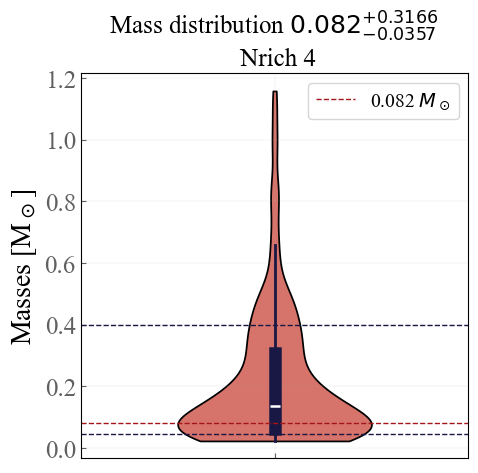

In [95]:
plt.figure(figsize=(5,5))


sns.violinplot(y = abs(np.array(M2_all)),inner_kws=dict(box_width=9, whis_width=2, color="#191743"),
               color = "#e3685c",saturation=0.8, fill=True, inner='box', split=False, width=0.5,
               dodge='auto', gap=0,density_norm='area',common_norm=False, bw_adjust=0.85,
              linecolor='k', cut=0, gridsize=250, native_scale=False)

# Calcula la densidad de la distribución
density = gaussian_kde(M2_all)

# Encuentra el rango de valores en el eje y
y_values = np.linspace(min(M2_all), max(M2_all), 1000)

# Evalúa la densidad en el rango de valores en el eje y
density_values = density(y_values)

# Encuentra el índice del máximo valor de densidad
peak_index = np.argmax(density_values)

# Encuentra el valor en el eje y correspondiente al pico
peak_value = y_values[peak_index]
percentile_16_mass = np.percentile(np.array(M2_all), 16)
percentile_84_mass = np.percentile(np.array(M2_all), 84)

# Calcular el error estimado (asimétrico)
error_lower_mass = (peak_value - percentile_16_mass)
error_upper_mass = (percentile_84_mass - peak_value)

#print("El pico más alto de la distribución está en:", peak_value)

# plt.axhline(y=M2.value, color='#D0D3D4', linestyle='--',linewidth = 1, label = f'$M_2$ = { round(float(M2.value),3)} $M_\odot$')
plt.axhline(y=peak_value, color='#a4161a', linestyle='--',linewidth = 1, label = f'{ round(peak_value,4)} $M_\odot$')
plt.axhline(peak_value-abs(error_lower_mass), color='#191743', linestyle='dashed', linewidth=1)
plt.axhline(peak_value+abs(error_upper_mass), color='#191743', linestyle='dashed', linewidth=1)
plt.tick_params(axis='both', labelsize=18,  direction="in", colors = "#605f61")  # Aumenta el tamaño de los números en ambos ejes

plt.ylabel("Masses [M$_\odot$]", fontsize = 20)
plt.title("Mass distribution"+f" ${round(peak_value,4)}^{{+{round(abs(error_upper_mass),4)}}}_{{-{round(abs(error_lower_mass),4)}}}$ \n Nrich 4", fontsize = 18)
plt.legend(fontsize = 14)
plt.grid(linestyle='-', linewidth=0.1)
plt.savefig("Mass_Nrich4.png", dpi=300, bbox_inches="tight")

plt.show()



In [97]:
print("Cálculamos la Masa con el pick más alto de la distribución de Periodos y con el pick más alto de la distribución de Masas")
print(f"La diferencia entre estos valores es: {abs(M2.value-peak_value)/abs(peak_value)*100} %")

Cálculamos la Masa con el pick más alto de la distribución de Periodos y con el pick más alto de la distribución de Masas
La diferencia entre estos valores es: 45.83677342785913 %


In [99]:
# Nombre del archivo
nombre_archivo = 'Mass_dist_Nrich4.csv'

# Escribir la lista en un archivo .csv
with open(nombre_archivo, mode='w', newline='') as archivo:
    escritor_csv = csv.writer(archivo)
    for elemento in M2_all:
        escritor_csv.writerow([elemento])

print(f"Lista guardada en {nombre_archivo}")

Lista guardada en Mass_dist_Nrich4.csv


In [101]:
Mc = peak_value*u.M_sun.to("M_jup")
Mme = error_upper_mass*u.M_sun.to("M_jup")
Mma = error_lower_mass*u.M_sun.to("M_jup")

print(f"Mass distribution {round(Mc,4)}^{{+{round(abs(Mme),4)}}}_{{-{round(abs(Mma),4)}}} \n")

Mass distribution 85.8843^{+331.6974}_{-37.4161} 



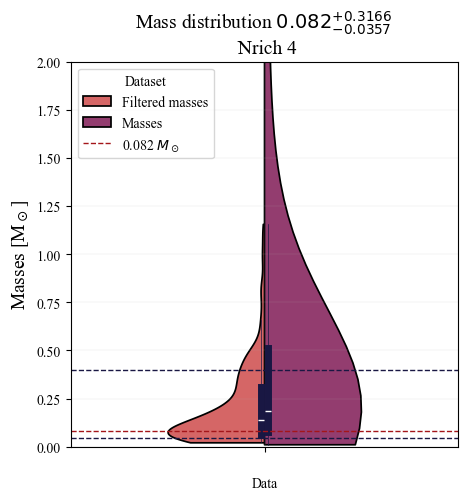

In [103]:
# Crear un DataFrame con las dos listas de datos
plt.figure(figsize=(5,5))

data = pd.DataFrame({
    'Value': M2_all + M2_all_full,
    'Dataset': ['Filtered masses'] * len(M2_all) + ['Masses'] * len(M2_all_full),
    'Data': ['  '] * len(M2_all) + ['  '] * len(M2_all_full)
})

# Crear el diagrama de violín con split=True usando la columna 'Category' para dividir los lados
sns.violinplot(x='Data', y='Value', hue='Dataset', data=data,inner_kws=dict(box_width=5, whis_width=0.5, color="#191743"),
               saturation=0.85, fill=True, inner='box', split=True, width=0.5,
               dodge='auto', gap=0,density_norm='area',common_norm=False, bw_adjust=0.85,
              linecolor='k', cut=0, gridsize=250, native_scale=False, palette = "flare")
plt.axhline(y=peak_value, color='#a4161a', linestyle='--',linewidth = 1, label = f'{ round(peak_value,4)} $M_\odot$')
plt.axhline(peak_value-abs(error_lower_mass), color='#191743', linestyle='dashed', linewidth=1)
plt.axhline(peak_value+abs(error_upper_mass), color='#191743', linestyle='dashed', linewidth=1)

# Ajustar el gráfico para que se vea mejor
plt.ylim(0,2)
plt.legend(loc='upper left',title='Dataset')
plt.title("Mass distribution"+f" ${round(peak_value,4)}^{{+{round(abs(error_upper_mass),4)}}}_{{-{round(abs(error_lower_mass),4)}}}$ \n Nrich 4", fontsize = 14)
plt.ylabel("Masses [M$_\odot$]", fontsize = 14)
plt.grid(linestyle='-', linewidth=0.1)
# Mostrar el gráfico
plt.show()

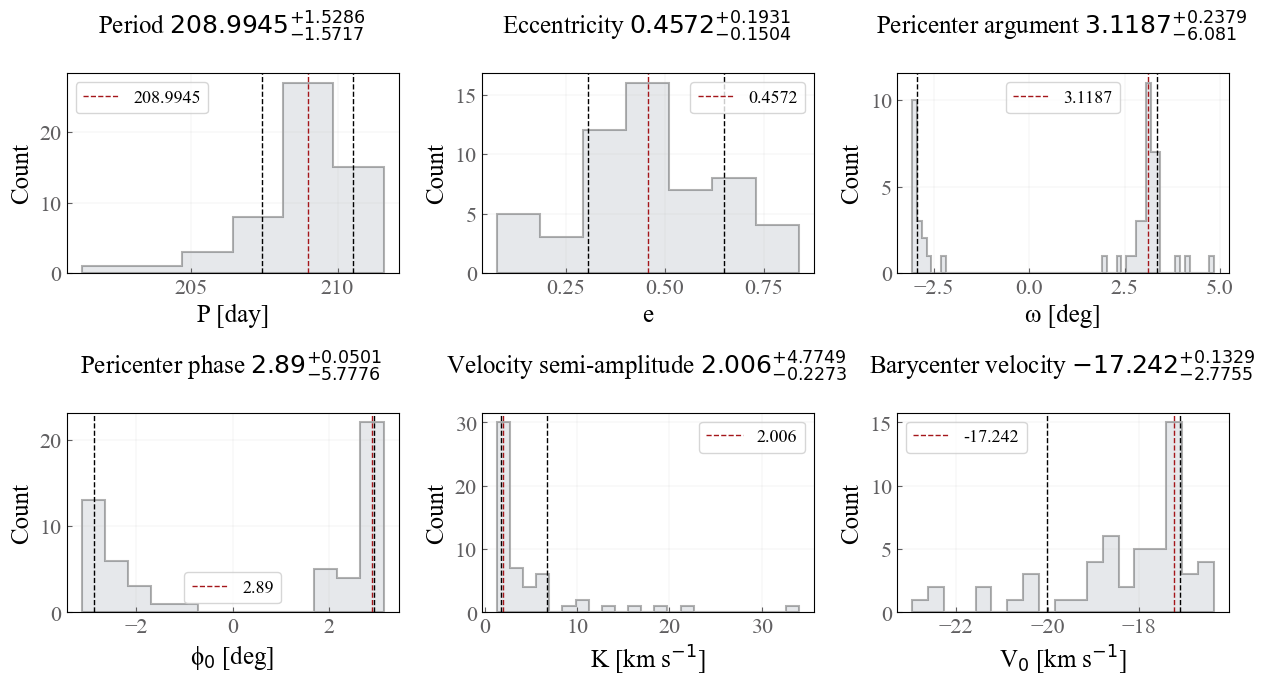

In [71]:
variables = ["P", "e", "omega", "M0", "K", "v0"]
xlabel = ["P [day]", "e", "ω [deg]", "ϕ$_0$ [deg]", "K [km s$^{-1}$]","V$_0$ [km s$^{-1}$]"]
title = ["Period","Eccentricity", "Pericenter argument", "Pericenter phase", "Velocity semi-amplitude", "Barycenter velocity"]
picos = []


fig = plt.figure(figsize=(15,7))

gs = fig.add_gridspec(2, 3, hspace=0.7, wspace=0.25)
(ax1,ax2,ax3), (ax4,ax5,ax6) = gs.subplots(sharey = False, sharex = False)

for ax,i in zip(fig.get_axes(),np.arange(len(variables))):
    ax.set_ylabel("Count", fontsize = 18)
    ax.set_xlabel(xlabel[i], fontsize = 18)
    conteos, bins, _  =  ax.hist(Filtrado_200[variables[i]], bins = "stone", histtype='stepfilled', density = False ,alpha=0.3, align = 'mid', color = '#adb5bd', ec="k")
    for patch in _:
        patch.set_edgecolor("k")  # Color del borde negro
        patch.set_linewidth(1.5)  # Gr
    # indice_maximo = np.argmax(conteos)
    # # Obtener el valor del pico más alto
    # pico_mas_alto = bins[indice_maximo]
    # picos.append(pico_mas_alto)
    # Calcular percentiles
    # Calcular el histograma y encontrar el pico (máximo de densidad)
    hist, bin_edges = np.histogram(Filtrado_200[variables[i]].value, bins="stone", density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    peak_index = np.argmax(hist)
    peak_value = bin_centers[peak_index]

    percentile_16 = np.percentile(Filtrado_200[variables[i]].value, 16)
    percentile_84 = np.percentile(Filtrado_200[variables[i]].value, 84)
    
    # Calcular el error estimado (asimétrico)
    error_lower = (peak_value - percentile_16)
    error_upper = (percentile_84 - peak_value)
    
    ax.set_title(title[i]+f" ${round(peak_value,4)}^{{+{round(abs(error_upper),4)}}}_{{-{round(abs(error_lower),4)}}}$ \n", fontsize = 18)

    # Agregar una línea vertical en el pico más alto
    #ax.axvline(x=pico_mas_alto, color='#a4161a', linestyle='--', linewidth = 1, label = f"{round(pico_mas_alto,2)}")
    ax.axvline(peak_value, color='#a4161a', linestyle='dashed', linewidth=1,label = f"{round(peak_value,4)}")
    ax.axvline(peak_value-abs(error_lower), color='k', linestyle='dashed', linewidth=1)
    ax.axvline(peak_value+abs(error_upper), color='k', linestyle='dashed', linewidth=1)
    ax.grid(linestyle='-', linewidth=0.1)
    ax.tick_params(axis='both', labelsize=16,  direction="in", colors = "#605f61") 
    ax.legend(fontsize = 13, loc = 'best')

plt.savefig("Parametros_Nrich4.png", dpi=300, bbox_inches="tight")


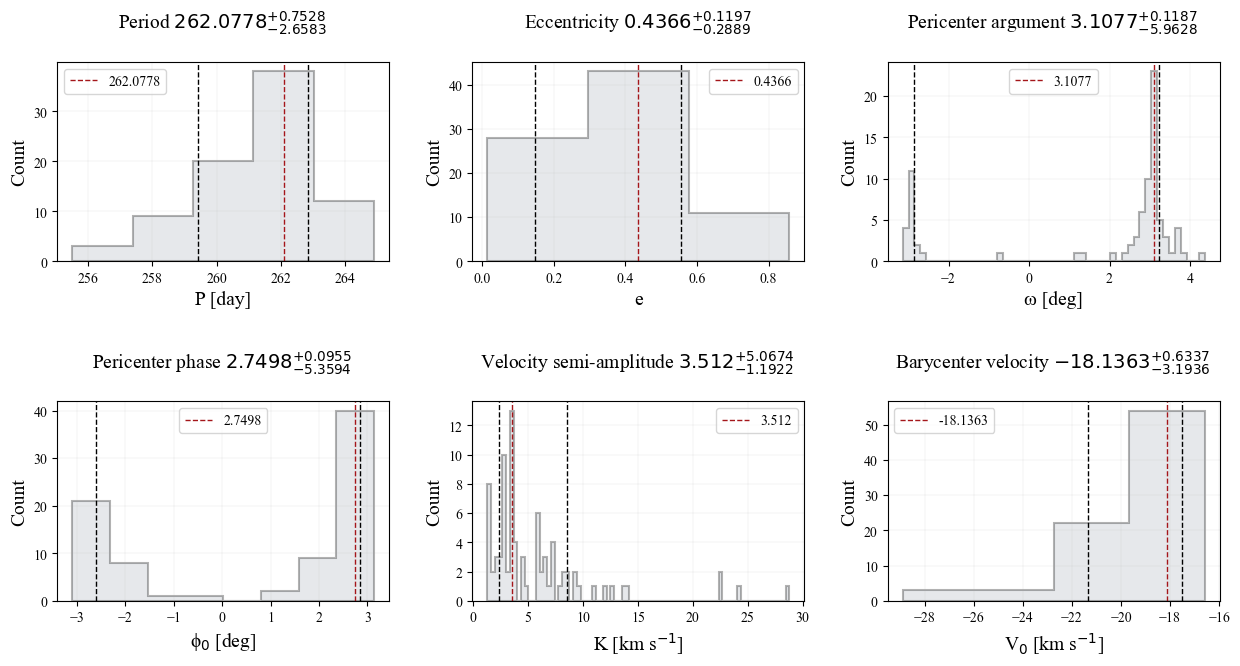

In [107]:
variables = ["P", "e", "omega", "M0", "K", "v0"]
xlabel = ["P [day]", "e", "ω [deg]", "ϕ$_0$ [deg]", "K [km s$^{-1}$]","V$_0$ [km s$^{-1}$]"]
title = ["Period","Eccentricity", "Pericenter argument", "Pericenter phase", "Velocity semi-amplitude", "Barycenter velocity"]
picos = []


fig = plt.figure(figsize=(15,7))

gs = fig.add_gridspec(2, 3,hspace=0.7, wspace=0.25)
(ax1,ax2,ax3), (ax4,ax5,ax6) = gs.subplots(sharey = False, sharex = False)

for ax,i in zip(fig.get_axes(),np.arange(len(variables))):
    ax.set_ylabel("Count", fontsize = 14)
    ax.set_xlabel(xlabel[i], fontsize = 14)
    conteos, bins, _  =  ax.hist(Filtrado_250[variables[i]], bins = "stone", histtype='stepfilled', density = False ,alpha=0.3, align = 'mid', color = '#adb5bd', ec="k")
    for patch in _:
        patch.set_edgecolor("k")  # Color del borde negro
        patch.set_linewidth(1.5)  # Gr
    # indice_maximo = np.argmax(conteos)
    # # Obtener el valor del pico más alto
    # pico_mas_alto = bins[indice_maximo]
    # picos.append(pico_mas_alto)
    # Calcular percentiles
    # Calcular el histograma y encontrar el pico (máximo de densidad)
    hist, bin_edges = np.histogram(Filtrado_250[variables[i]].value, bins="stone", density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    peak_index = np.argmax(hist)
    peak_value = bin_centers[peak_index]

    percentile_16 = np.percentile(Filtrado_250[variables[i]].value, 16)
    percentile_84 = np.percentile(Filtrado_250[variables[i]].value, 84)
    
    # Calcular el error estimado (asimétrico)
    error_lower = (peak_value - percentile_16)
    error_upper = (percentile_84 - peak_value)
    
    ax.set_title(title[i]+f" ${round(peak_value,4)}^{{+{round(abs(error_upper),4)}}}_{{-{round(abs(error_lower),4)}}}$ \n", fontsize = 14)

    # Agregar una línea vertical en el pico más alto
    #ax.axvline(x=pico_mas_alto, color='#a4161a', linestyle='--', linewidth = 1, label = f"{round(pico_mas_alto,2)}")
    ax.axvline(peak_value, color='#a4161a', linestyle='dashed', linewidth=1,label = f"{round(peak_value,4)}")
    ax.axvline(peak_value-abs(error_lower), color='k', linestyle='dashed', linewidth=1)
    ax.axvline(peak_value+abs(error_upper), color='k', linestyle='dashed', linewidth=1)
    ax.grid(linestyle='-', linewidth=0.1)
    ax.legend()

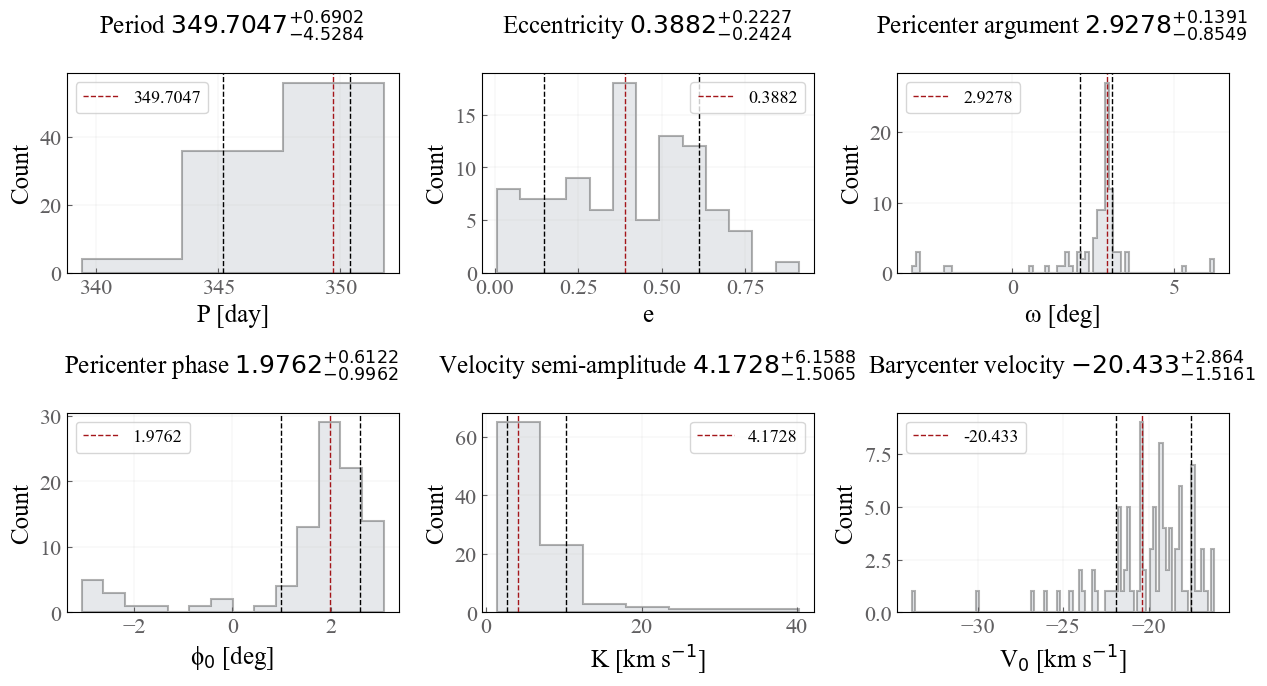

In [109]:
variables = ["P", "e", "omega", "M0", "K", "v0"]
xlabel = ["P [day]", "e", "ω [deg]", "ϕ$_0$ [deg]", "K [km s$^{-1}$]","V$_0$ [km s$^{-1}$]"]
title = ["Period","Eccentricity", "Pericenter argument", "Pericenter phase", "Velocity semi-amplitude", "Barycenter velocity"]
picos = []


fig = plt.figure(figsize=(15,7))

gs = fig.add_gridspec(2, 3, hspace=0.7, wspace=0.25)
(ax1,ax2,ax3), (ax4,ax5,ax6) = gs.subplots(sharey = False, sharex = False)

for ax,i in zip(fig.get_axes(),np.arange(len(variables))):
    ax.set_ylabel("Count", fontsize = 18)
    ax.set_xlabel(xlabel[i], fontsize = 18)
    conteos, bins, _  =  ax.hist(Filtrado_300[variables[i]], bins = "stone", histtype='stepfilled', density = False ,alpha=0.3, align = 'mid', color = '#adb5bd', ec="k")
    for patch in _:
        patch.set_edgecolor("k")  # Color del borde negro
        patch.set_linewidth(1.5)  # Gr
    # indice_maximo = np.argmax(conteos)
    # # Obtener el valor del pico más alto
    # pico_mas_alto = bins[indice_maximo]
    # picos.append(pico_mas_alto)
    # Calcular percentiles
    # Calcular el histograma y encontrar el pico (máximo de densidad)
    hist, bin_edges = np.histogram(Filtrado_300[variables[i]].value, bins="stone", density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    peak_index = np.argmax(hist)
    peak_value = bin_centers[peak_index]

    percentile_16 = np.percentile(Filtrado_300[variables[i]].value, 16)
    percentile_84 = np.percentile(Filtrado_300[variables[i]].value, 84)
    
    # Calcular el error estimado (asimétrico)
    error_lower = (peak_value - percentile_16)
    error_upper = (percentile_84 - peak_value)
    
    ax.set_title(title[i]+f" ${round(peak_value,4)}^{{+{round(abs(error_upper),4)}}}_{{-{round(abs(error_lower),4)}}}$ \n", fontsize = 18)

    # Agregar una línea vertical en el pico más alto
    #ax.axvline(x=pico_mas_alto, color='#a4161a', linestyle='--', linewidth = 1, label = f"{round(pico_mas_alto,2)}")
    ax.axvline(peak_value, color='#a4161a', linestyle='dashed', linewidth=1,label = f"{round(peak_value,4)}")
    ax.axvline(peak_value-abs(error_lower), color='k', linestyle='dashed', linewidth=1)
    ax.axvline(peak_value+abs(error_upper), color='k', linestyle='dashed', linewidth=1)
    ax.grid(linestyle='-', linewidth=0.1)
    ax.tick_params(axis='both', labelsize=16,  direction="in", colors = "#605f61") 
    ax.legend(fontsize = 13, loc = 'best')

plt.savefig("Parametros_Nrich4.png", dpi=300, bbox_inches="tight")


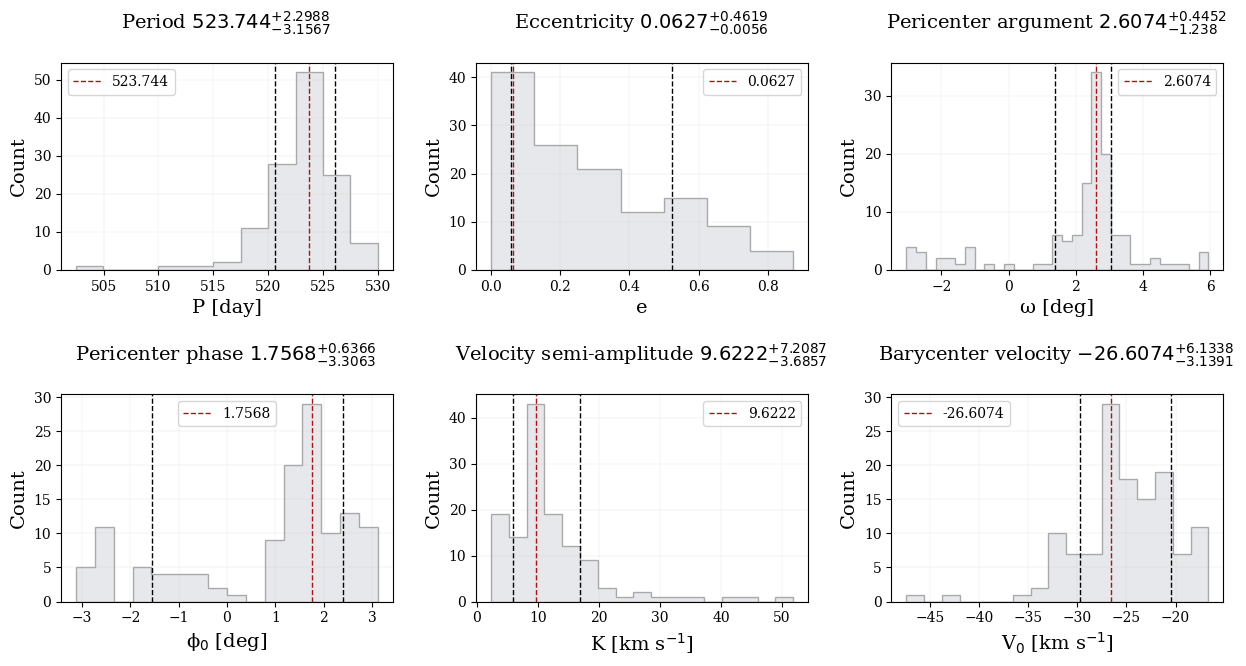

In [83]:
variables = ["P", "e", "omega", "M0", "K", "v0"]
xlabel = ["P [day]", "e", "ω [deg]", "ϕ$_0$ [deg]", "K [km s$^{-1}$]","V$_0$ [km s$^{-1}$]"]
title = ["Period","Eccentricity", "Pericenter argument", "Pericenter phase", "Velocity semi-amplitude", "Barycenter velocity"]
picos = []


fig = plt.figure(figsize=(15,7))

gs = fig.add_gridspec(2, 3, hspace=0.6, wspace=0.25)
(ax1,ax2,ax3), (ax4,ax5,ax6) = gs.subplots(sharey = False, sharex = False)

for ax,i in zip(fig.get_axes(),np.arange(len(variables))):
    ax.set_ylabel("Count", fontsize = 14)
    ax.set_xlabel(xlabel[i], fontsize = 14)
    conteos, bins, _  =  ax.hist(Filtrado_500[variables[i]], bins = "stone", histtype='stepfilled', density = False ,alpha=0.3, align = 'mid', color = '#adb5bd', ec="k")
    # indice_maximo = np.argmax(conteos)
    # # Obtener el valor del pico más alto
    # pico_mas_alto = bins[indice_maximo]
    # picos.append(pico_mas_alto)
    # Calcular percentiles
    # Calcular el histograma y encontrar el pico (máximo de densidad)
    hist, bin_edges = np.histogram(Filtrado_500[variables[i]].value, bins="stone", density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    peak_index = np.argmax(hist)
    peak_value = bin_centers[peak_index]

    percentile_16 = np.percentile(Filtrado_500[variables[i]].value, 16)
    percentile_84 = np.percentile(Filtrado_500[variables[i]].value, 84)
    
    # Calcular el error estimado (asimétrico)
    error_lower = (peak_value - percentile_16)
    error_upper = (percentile_84 - peak_value)
    
    ax.set_title(title[i]+f" ${round(peak_value,4)}^{{+{round(abs(error_upper),4)}}}_{{-{round(abs(error_lower),4)}}}$ \n", fontsize = 14)

    # Agregar una línea vertical en el pico más alto
    #ax.axvline(x=pico_mas_alto, color='#a4161a', linestyle='--', linewidth = 1, label = f"{round(pico_mas_alto,2)}")
    ax.axvline(peak_value, color='#a4161a', linestyle='dashed', linewidth=1,label = f"{round(peak_value,4)}")
    ax.axvline(peak_value-abs(error_lower), color='k', linestyle='dashed', linewidth=1)
    ax.axvline(peak_value+abs(error_upper), color='k', linestyle='dashed', linewidth=1)
    ax.grid(linestyle='-', linewidth=0.1)
    ax.legend()

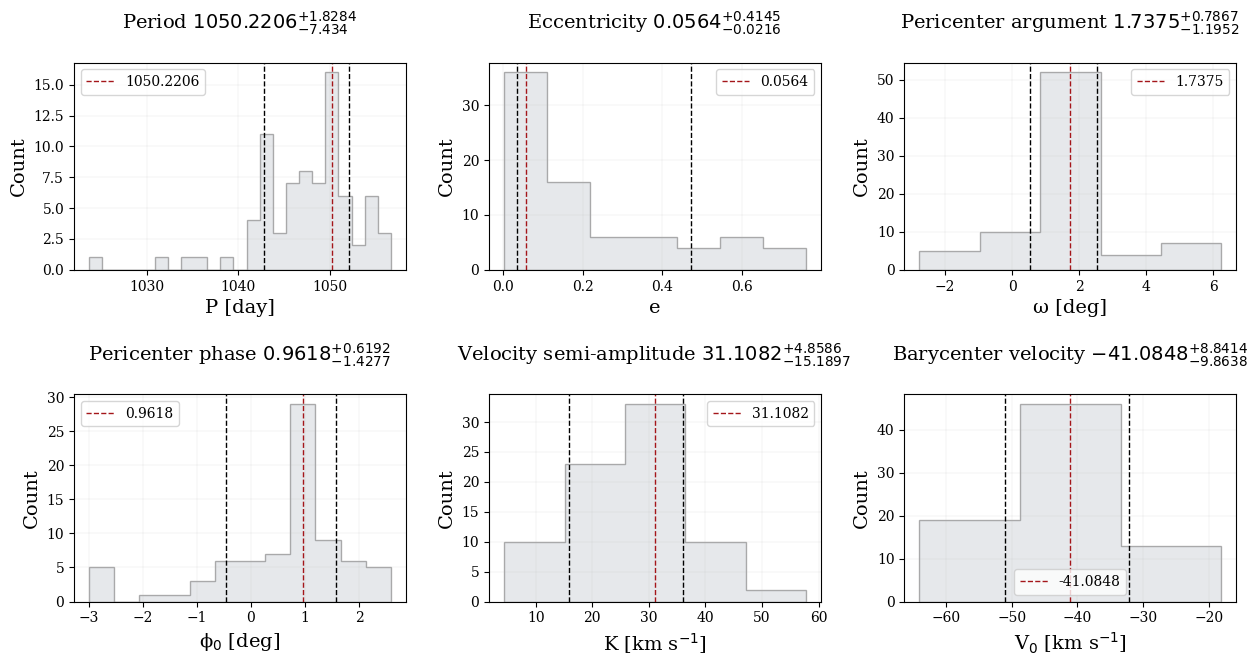

In [84]:
variables = ["P", "e", "omega", "M0", "K", "v0"]
xlabel = ["P [day]", "e", "ω [deg]", "ϕ$_0$ [deg]", "K [km s$^{-1}$]","V$_0$ [km s$^{-1}$]"]
title = ["Period","Eccentricity", "Pericenter argument", "Pericenter phase", "Velocity semi-amplitude", "Barycenter velocity"]
picos = []


fig = plt.figure(figsize=(15,7))

gs = fig.add_gridspec(2, 3, hspace=0.6, wspace=0.25)
(ax1,ax2,ax3), (ax4,ax5,ax6) = gs.subplots(sharey = False, sharex = False)

for ax,i in zip(fig.get_axes(),np.arange(len(variables))):
    ax.set_ylabel("Count", fontsize = 14)
    ax.set_xlabel(xlabel[i], fontsize = 14)
    conteos, bins, _  =  ax.hist(Filtrado_1000[variables[i]], bins = "stone", histtype='stepfilled', density = False ,alpha=0.3, align = 'mid', color = '#adb5bd', ec="k")
    # indice_maximo = np.argmax(conteos)
    # # Obtener el valor del pico más alto
    # pico_mas_alto = bins[indice_maximo]
    # picos.append(pico_mas_alto)
    # Calcular percentiles
    # Calcular el histograma y encontrar el pico (máximo de densidad)
    hist, bin_edges = np.histogram(Filtrado_1000[variables[i]].value, bins="stone", density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    peak_index = np.argmax(hist)
    peak_value = bin_centers[peak_index]

    percentile_16 = np.percentile(Filtrado_1000[variables[i]].value, 16)
    percentile_84 = np.percentile(Filtrado_1000[variables[i]].value, 84)
    
    # Calcular el error estimado (asimétrico)
    error_lower = (peak_value - percentile_16)
    error_upper = (percentile_84 - peak_value)
    
    ax.set_title(title[i]+f" ${round(peak_value,4)}^{{+{round(abs(error_upper),4)}}}_{{-{round(abs(error_lower),4)}}}$ \n", fontsize = 14)

    # Agregar una línea vertical en el pico más alto
    #ax.axvline(x=pico_mas_alto, color='#a4161a', linestyle='--', linewidth = 1, label = f"{round(pico_mas_alto,2)}")
    ax.axvline(peak_value, color='#a4161a', linestyle='dashed', linewidth=1,label = f"{round(peak_value,4)}")
    ax.axvline(peak_value-abs(error_lower), color='k', linestyle='dashed', linewidth=1)
    ax.axvline(peak_value+abs(error_upper), color='k', linestyle='dashed', linewidth=1)
    ax.grid(linestyle='-', linewidth=0.1)
    ax.legend()

### <span style="color:red"> Análisis de la estrella </span>

El objeto TYC250-1352-1 cuenta con un total de seis épocas de observación. En estas, se presenta un comportamiento bastante multimodal en los resultados de las simulaciones de Monte Carlo. En este caso, es muy complicado poder establecer un periodo más significativo respecto al otro, esto debido a que los datos que se tienen son pocos y poco informativos, los resultados muestran que incluso podemos estar hablando de un periodo y sus armónicos, el problema es que no se logra distinguir con claridad cual de estos periodos es el principal, por lo mencionado anteriormente. 

Además, al ver los resultados de cada sector de periodos podemos notar que las órbitas obtenidas muestran un comportamiento congruente, pues al ver los puntos en fase, logramos observar que estos puntos se encuentran principalmente en la misma zona de la órbita, estamos hablando en la zona más arriba de la órbita respecto a su velocidad radial, lo que también explica un poco este comportamiento tan multimodal. En este caso, sería bastante útil poder encontrar puntos de velocidad radial en las zonas más bajas de la órbita en cuanto a velocidad radial, sería importante plantearse la posibilidad de obtener observaciones para fechas que estén distribuídas en esas zonas de las órbitas para descartar o confirmar cierta periodicidad significativa, de la siguiente manera: 

* La posible fecha de observación para P = [209.06954265] d es: [60754.41725588] = ['2025-03-20 10:00:50.908']
* La posible fecha de observación para P = [261.61821491] d es: [60758.09107454]  = ['2025-03-24 02:11:08.840']
* La posible fecha de observación para P = [348.12847878] d es: [60757.51391513]  = ['2025-03-23 12:20:02.267']
* La posible fecha de observación para P = [523.52709753] d es: [60905.58129259]  = ['2025-08-18 13:57:03.680']
* La posible fecha de observación para P = [1048.24934803] d es: [61096.49869606]  = ['2026-02-25 11:58:07.339']

Se realizó el calculo para la distribución de la masa por medio de los parámetros obtenidos, asumiendo entonces para la estrella visible una masa de $0.8 M_\odot$ la masa cálculada para el segundo objeto sería de $0.082^{+0.317}_{-0.036} ~ M_\odot$, o bien $85.8843^{+331.6974}_{-37.4161} ~ M_J $, que estaría dentro del rango de un objeto subestelar o estelar. Para las estrellas enanas marrones su masa es aproximadamente de $13 - 80$ veces la de Júpiter ( $M_J$ ).

### Estimación de la masa

In [134]:
B = 12.360 
V = 11.400
B_V = B-V
B_V

0.9599999999999991

#### Magnitud absoluta:

$$M = m - 5(log_{10}(d_{pc})-1)$$

In [135]:
m_V = V
d = np.mean([1293.810,1406.272,1307.8734,1138.96]) # Distancias encontradas en Simbad en pc
M=m_V-5*(np.log10(d)-1)
M

0.8525648076515715

#### Luminosidad

$$M = M_{\odot} - 2.5 \log_{10}\left(\frac{L}{L_{\odot}}\right)$$

$$L = 10^{-\frac{M-M_\odot}{2.5}}L_{\odot}$$

In [136]:
L=10**(-(M-4.83)/2.5)
L

38.9918711713353

In [137]:
masa = L**(1/3)
masa

3.3909758148752305